### Background

This Jupyter notebook documents the feature extractions discussed in the Zamzmi et al (2025). Features include:
* pixel intensities (e.g., mean, standard deviation, skewness)
* average edge intensity
* contrast
* brightness
* energy features 
* topological features: betti 0 & betti 1 

Zamzmi G, Subbaswamy A, Sizikova E, Margerrison E, Delfino JG, Badano A. Scorecard for synthetic medical data evaluation. Commun Eng. 2025 Jul 21;4(1):130. doi: 10.1038/s44172-025-00450-1. PMID: 40691520; PMCID: PMC12280076.

### Packages and Datasets

In [ ]:
#################################
## Import packages
#################################

import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from gudhi import CubicalComplex
from skimage import feature
from glob import glob


In [2]:
#################################
## Define constants
#################################

# Define the directory path for saving features
FEATURE_DIR = 'outputs/features/'
os.makedirs (FEATURE_DIR, exist_ok=True)

# List of pre-processed datasets
IMAGE_MAIN_DIR = "/projects01/didsr-aiml/yeelamelim.thompson/SyDE/GhadaData/20250512/preProcessed/"
datasets = {
    'VinDr': IMAGE_MAIN_DIR + 'VinDr/VinDr_processed/equalized_images/*.png',
    'DDSM': IMAGE_MAIN_DIR + 'DDSM/DDSM_processed/DDSM_images_resized/*',
    'InBreast': IMAGE_MAIN_DIR + 'InBreast/INbreast_processed/INbreast_cropped_DICOM_images_resized/center_cropped/equalized_images/*.png',
    'MIAS': IMAGE_MAIN_DIR + 'MIAS/MIAS_processed/all-mias_cropped_images_resized/all-mias_cropped_images_resized_norm/*.png',
    'HuggingFace': IMAGE_MAIN_DIR + 'HuggingFace/HuggingFace_processed/*',
    'Mammo_medigan': IMAGE_MAIN_DIR + 'medigan/medigan_processed/*'
}

In [3]:
for dsetname, dsetpath in datasets.items():
    print (dsetname, len (glob (dsetpath)))

# VinDr 9045
# DDSM 321
# InBreast 411
# MIAS 323
# HuggingFace 1451
# Mammo_medigan 2126

VinDr 9045
DDSM 321
InBreast 411
MIAS 323
HuggingFace 1451
Mammo_medigan 2126


### Feature Calculations


In [4]:
def compute_features(image_array):
    # Histogram-based features
    mean_val = np.mean(image_array)
    std_val = np.std(image_array)
    skewness = stats.skew(image_array.flatten())
    kurtosis = stats.kurtosis(image_array.flatten())
    median_val = np.median(image_array)

    # Edge-based features
    # Find edges via derivative of the Gaussian of 1sigma width
    # `edges` is true/false per pixel. True if the pixel is an edge
    edges = feature.canny(image_array)
    # Number of edge-pixel per image
    edge_density = np.sum(edges) / edges.size
    # Mean pixel values from all edge-pixel
    avg_edge_intensity = np.mean(image_array[edges])

    # Fourier transform features
    # https://sbme-tutorials.github.io/2018/cv/notes/3_week3.html
    f_transform = np.fft.fft2(image_array)
    f_transform_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shift)
    low_freq_energy = np.sum(magnitude_spectrum[:10, :10])
    high_freq_energy = np.sum(magnitude_spectrum[-10:, -10:])

    # Topological features using Persistent Homology
    # https://gudhi.inria.fr/python/latest/cubical_complex_user.html
    cubical_complex = CubicalComplex(dimensions=image_array.shape,
                                     top_dimensional_cells=image_array.flatten())
    persistence = cubical_complex.persistence()
    # Betti_0 = # connected components (i.e. isolated objects)
    # Betti_1 = # 1D holes (i.e. tunnels or loops)
    betti_0 = sum(1 for p in persistence if p[0] == 0)
    betti_1 = sum(1 for p in persistence if p[0] == 1)

    features = [mean_val, std_val, skewness, kurtosis, median_val,
                edge_density, avg_edge_intensity, low_freq_energy, high_freq_energy,
                betti_0, betti_1]

    return features

# Define the feature columns
FEATURE_COLUMNS = [
    'mean', 'std', 'skewness', 'kurtosis', 'median',
    'edge_density', 'avg_edge_intensity', 'low_freq_energy', 'high_freq_energy',
    'betti_0', 'betti_1']

### Feature Extractions

In [5]:
ALLOWED_IMAGE_FORMATS = ('.jpg', '.jpeg', '.png', '.tif', '.tiff', '.dicom', '.dcm')

# Initialize a dictionary to store features for each dataset
dataset_features = {}

# Extract features for each dataset
for dataset_name, dataset_path in datasets.items():
    # If the feature csv file already exists, pull them out
    feature_csv = FEATURE_DIR + f'/{dataset_name}_features.csv'
    if os.path.exists (feature_csv):
        dataset_df = pd.read_csv(feature_csv)
        dataset_features[dataset_name] = dataset_df  
        continue

    # If csv file hasn't existed yet, extract features now!
    image_features = []
    all_files = [filename for filename in glob(dataset_path)
                 if filename.lower().endswith(ALLOWED_IMAGE_FORMATS) and not 'grid' in filename.lower()]

    # Iterate through the image files with a progress bar
    for image_path in tqdm(all_files, desc=f'Processing {dataset_name}', unit='file'):
        ## 'L' turns RGB into 8-bit black-white
        ## options for convert modes: https://www.codecademy.com/resources/docs/pillow/image/convert
        img = Image.open(image_path).convert('L')
        img_array = np.array(img)
        features = compute_features(img_array)
        image_features.append(features)

    # Store extracted features in a DataFrame and save to CSV
    dataset_df = pd.DataFrame(image_features, columns=FEATURE_COLUMNS)
    dataset_df.to_csv(feature_csv, index=False)
    dataset_features[dataset_name] = dataset_df

# Print summary information 
for dataset_name, features_df in dataset_features.items():
    print ("+-------------------------------------------------")
    print(f"Extracted features for {dataset_name}:")
    print(features_df.head())  

+-------------------------------------------------
Extracted features for VinDr:
         mean         std  skewness  kurtosis  median  edge_density  \
0   39.921417   62.872815  1.224765 -0.283839     3.0      0.047375   
1   21.290958   48.697294  2.430874  4.266244     3.0      0.028004   
2   25.777565   53.368501  2.086023  2.741712     3.0      0.031689   
3  157.391315  109.001924 -0.464924 -1.528515   207.0      0.049438   
4   51.252144   79.173923  1.057512 -0.837124     3.0      0.010242   

   avg_edge_intensity  low_freq_energy  high_freq_energy  betti_0  betti_1  
0          134.269990     25950.294325      26136.639308     2270     3583  
1          134.242201     17777.160893      19406.172369     1247     1927  
2          134.237029     19547.575591      19675.213719     1736     2737  
3          129.521682     21368.252945      20312.628935     1807     2607  
4          135.786220     20830.845021      22291.560687     2304     3570  
+-----------------------------

### Feature Distribution Comparisons

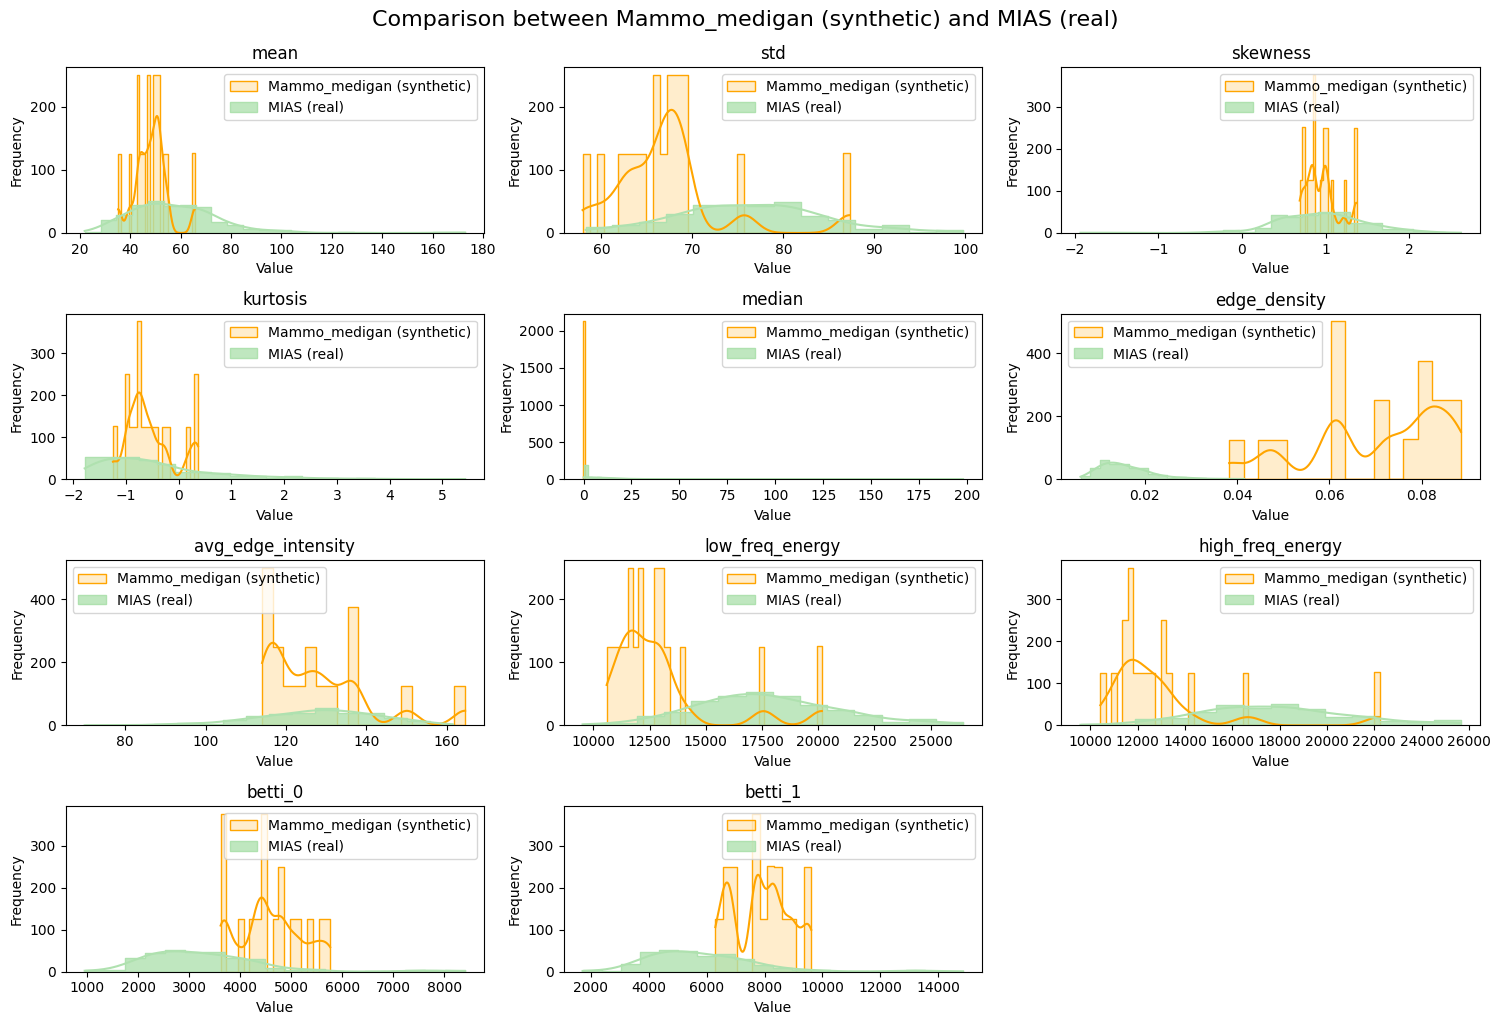

<Figure size 640x480 with 0 Axes>

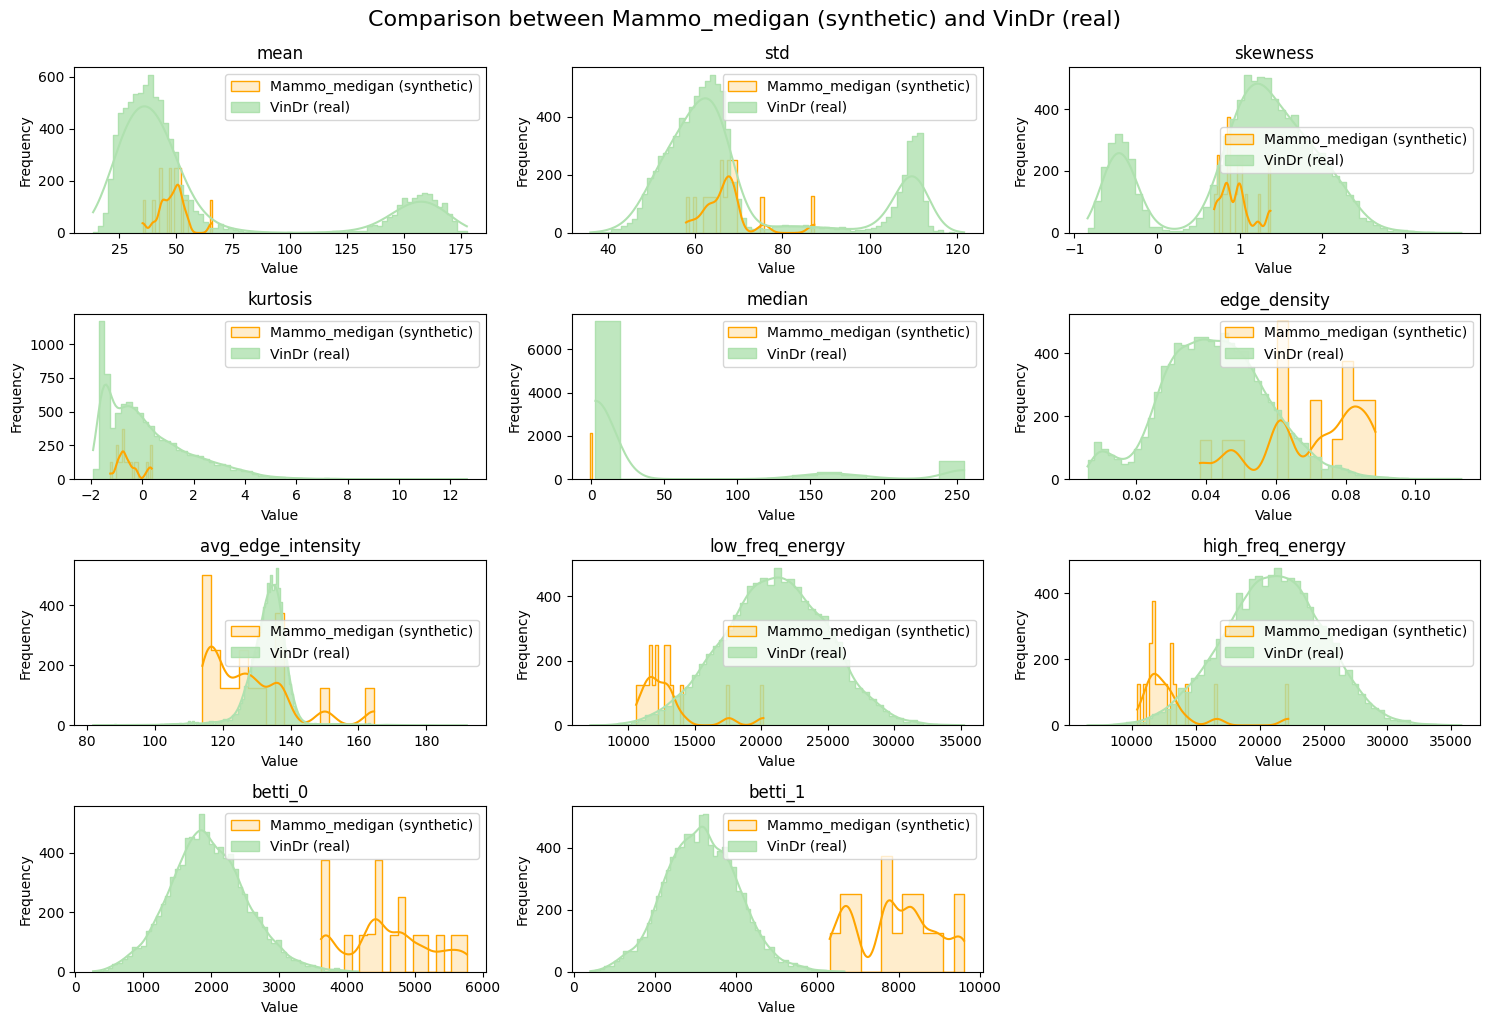

<Figure size 640x480 with 0 Axes>

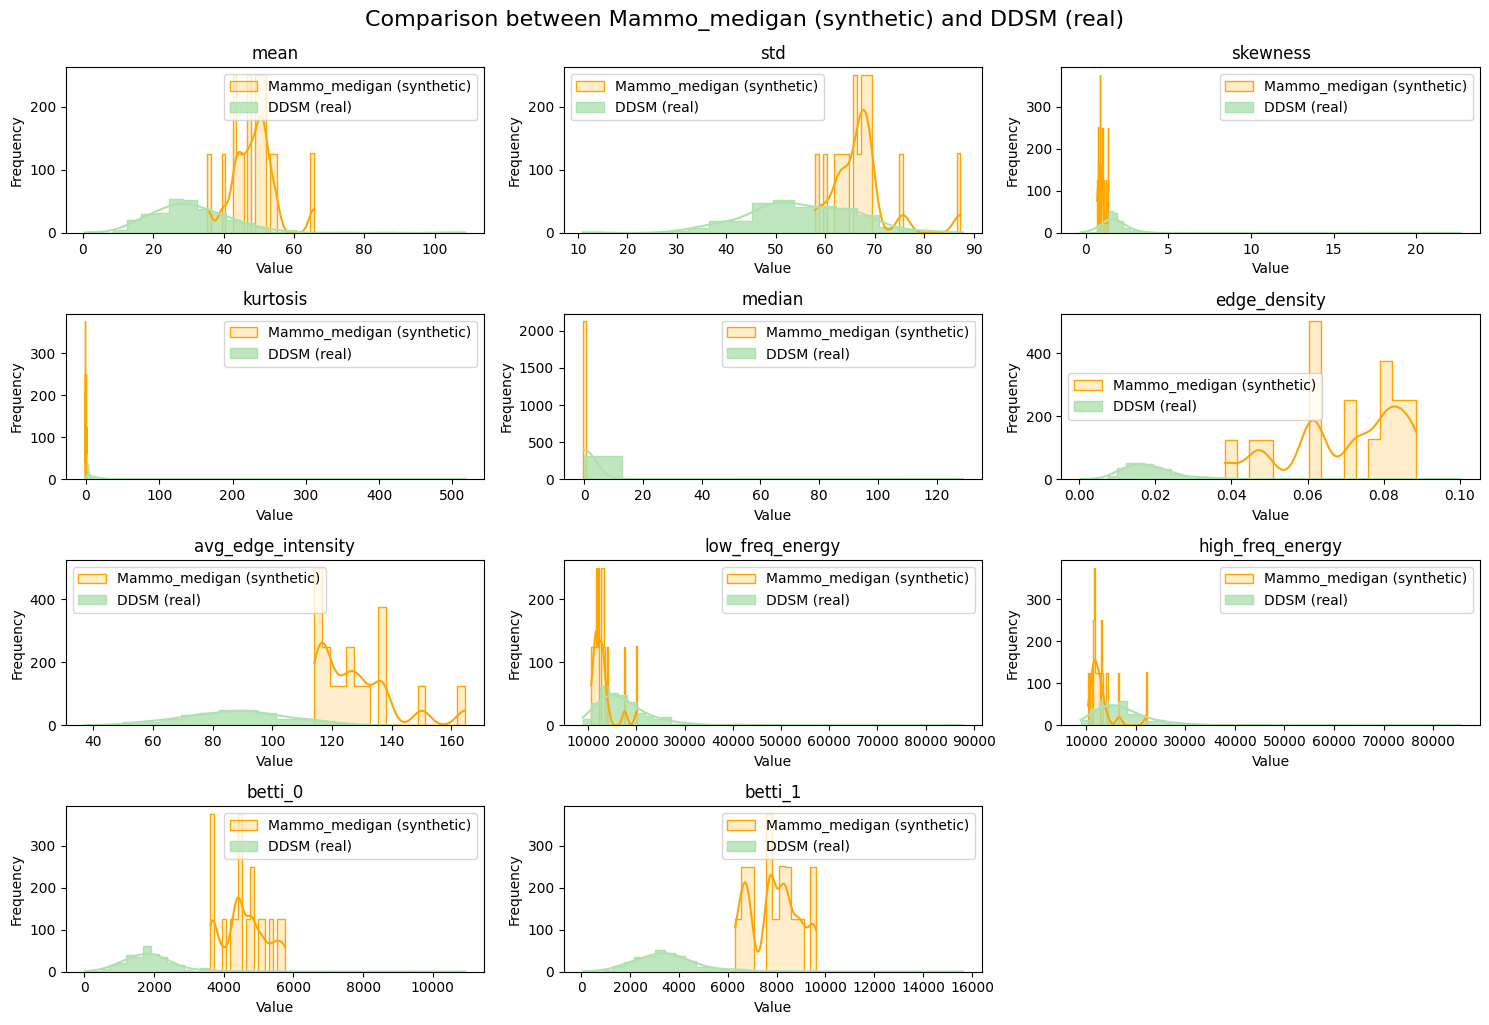

<Figure size 640x480 with 0 Axes>

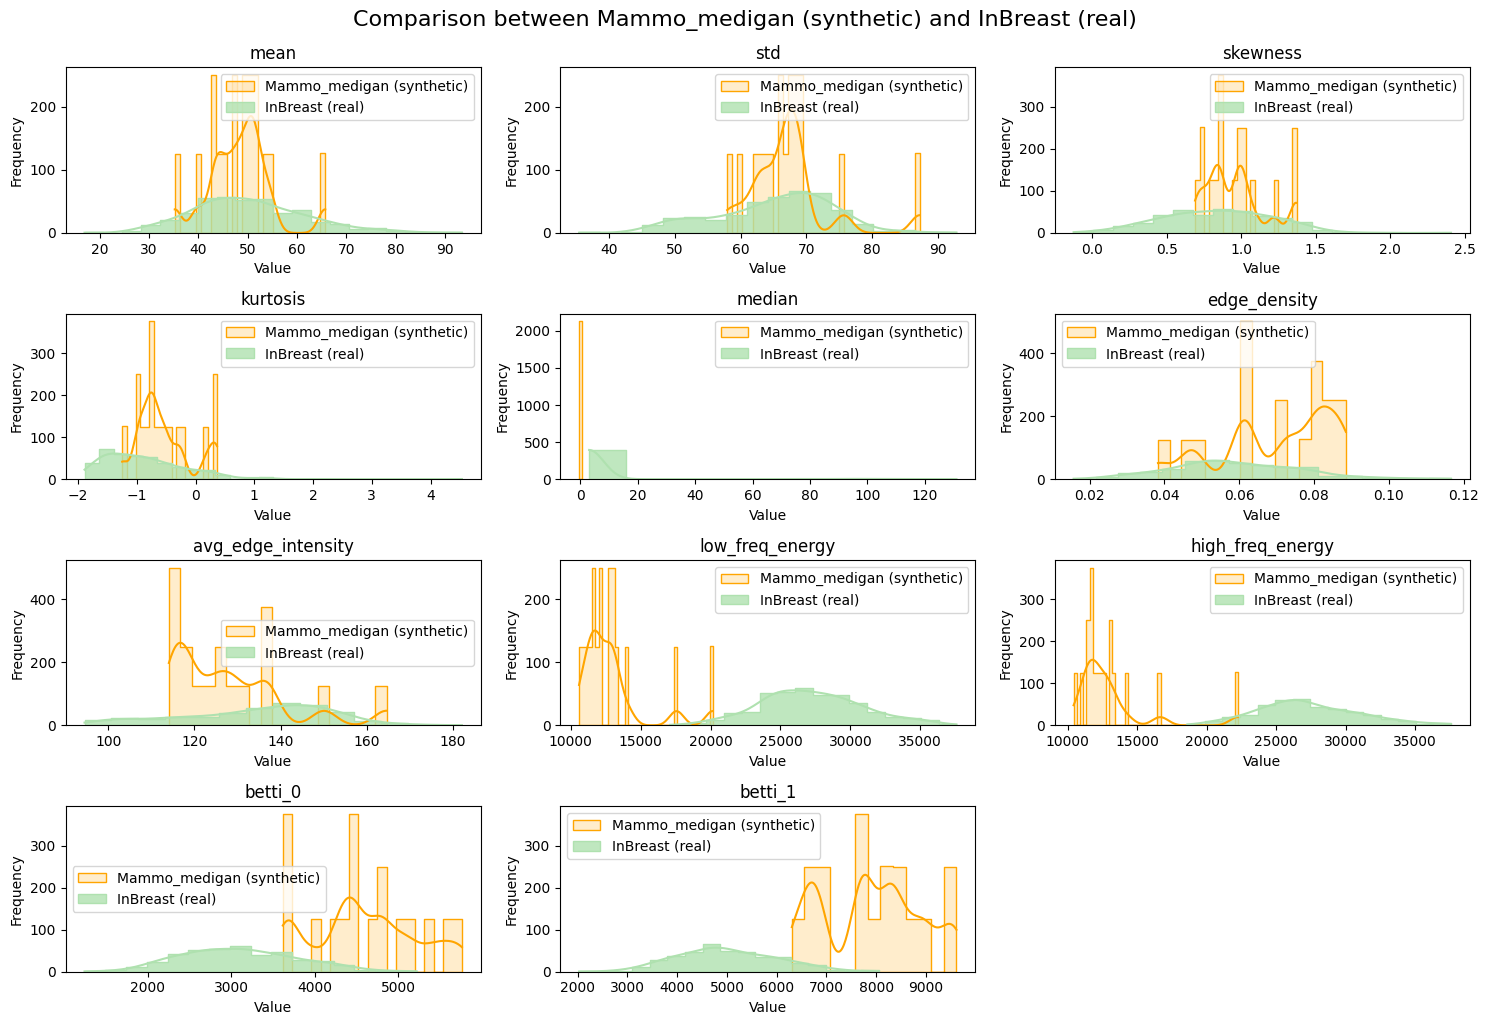

<Figure size 640x480 with 0 Axes>

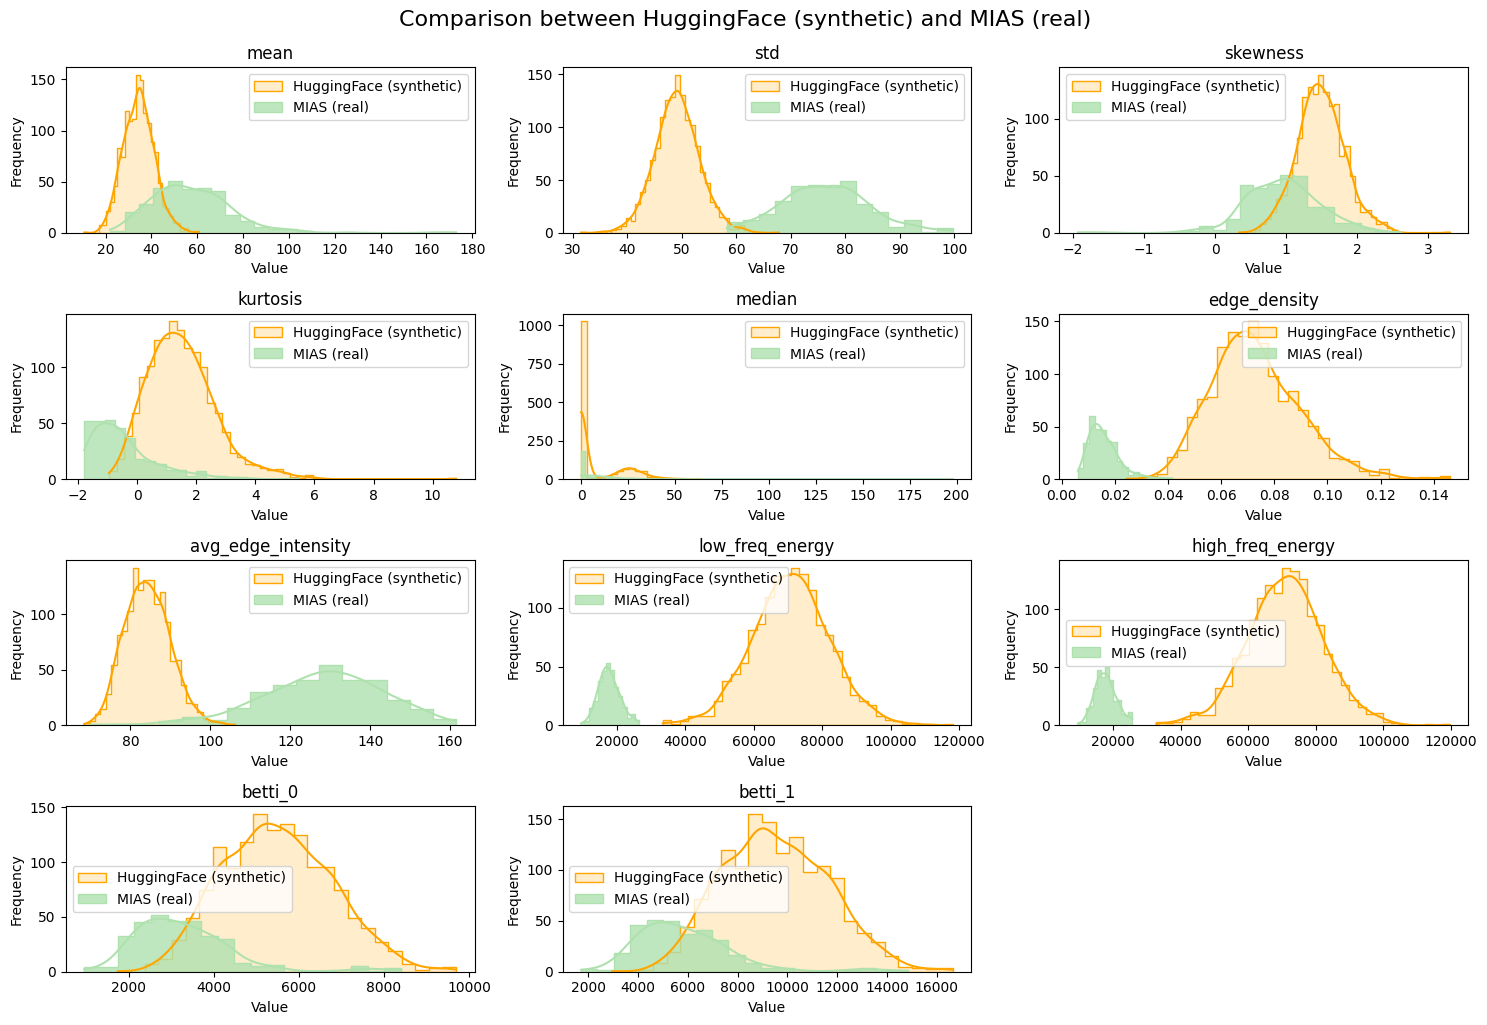

<Figure size 640x480 with 0 Axes>

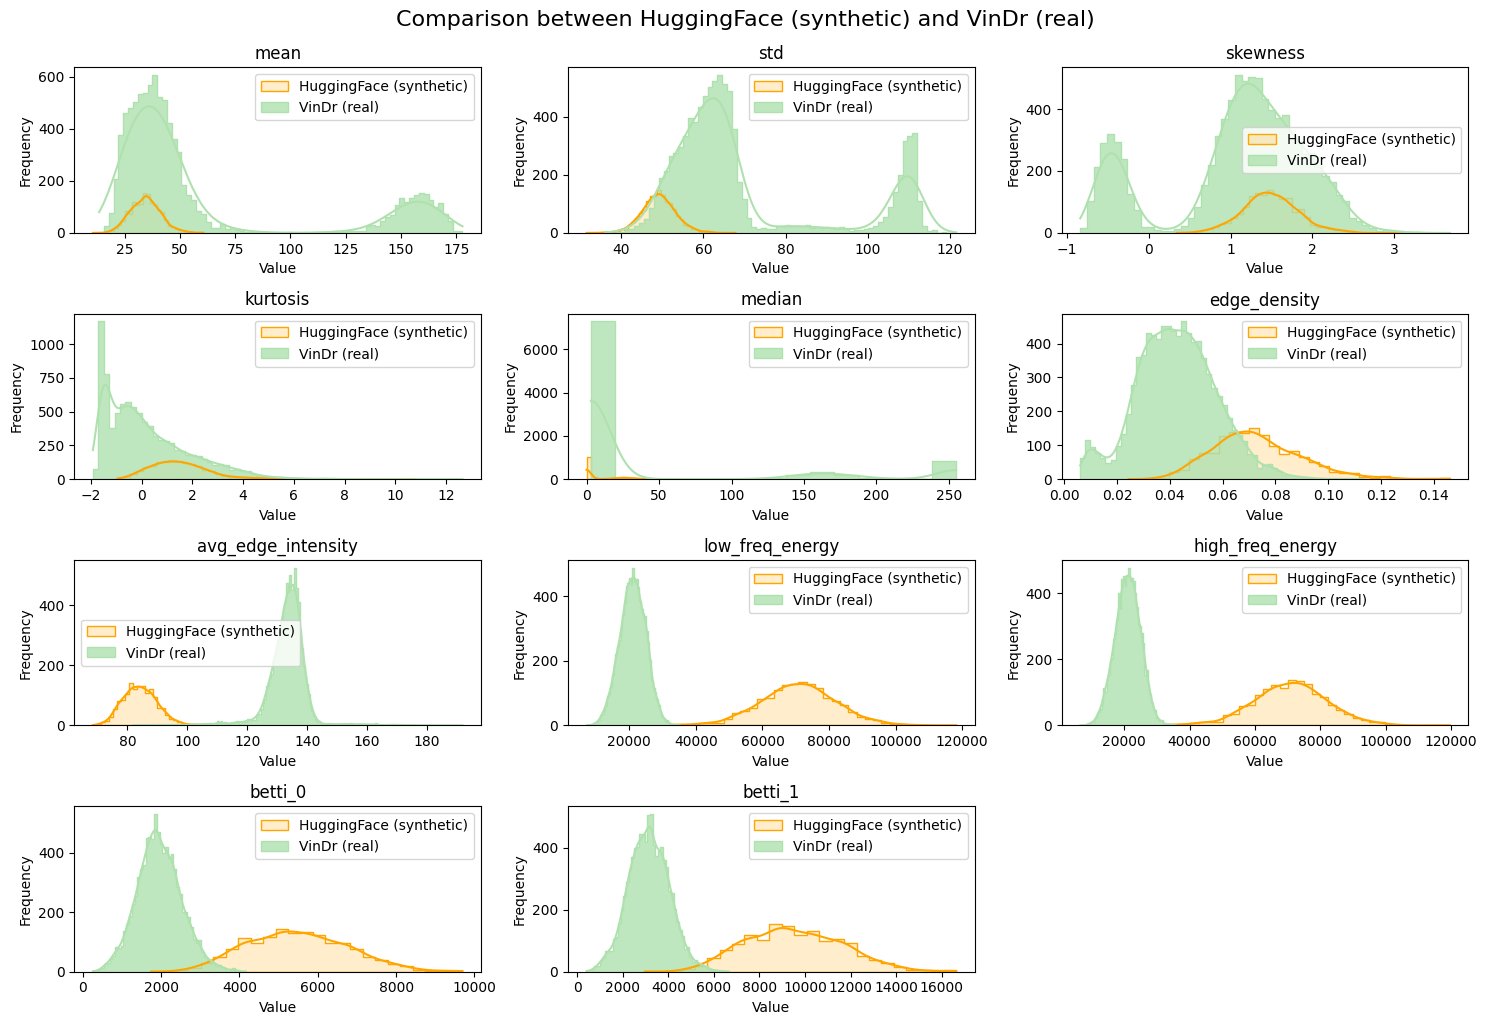

<Figure size 640x480 with 0 Axes>

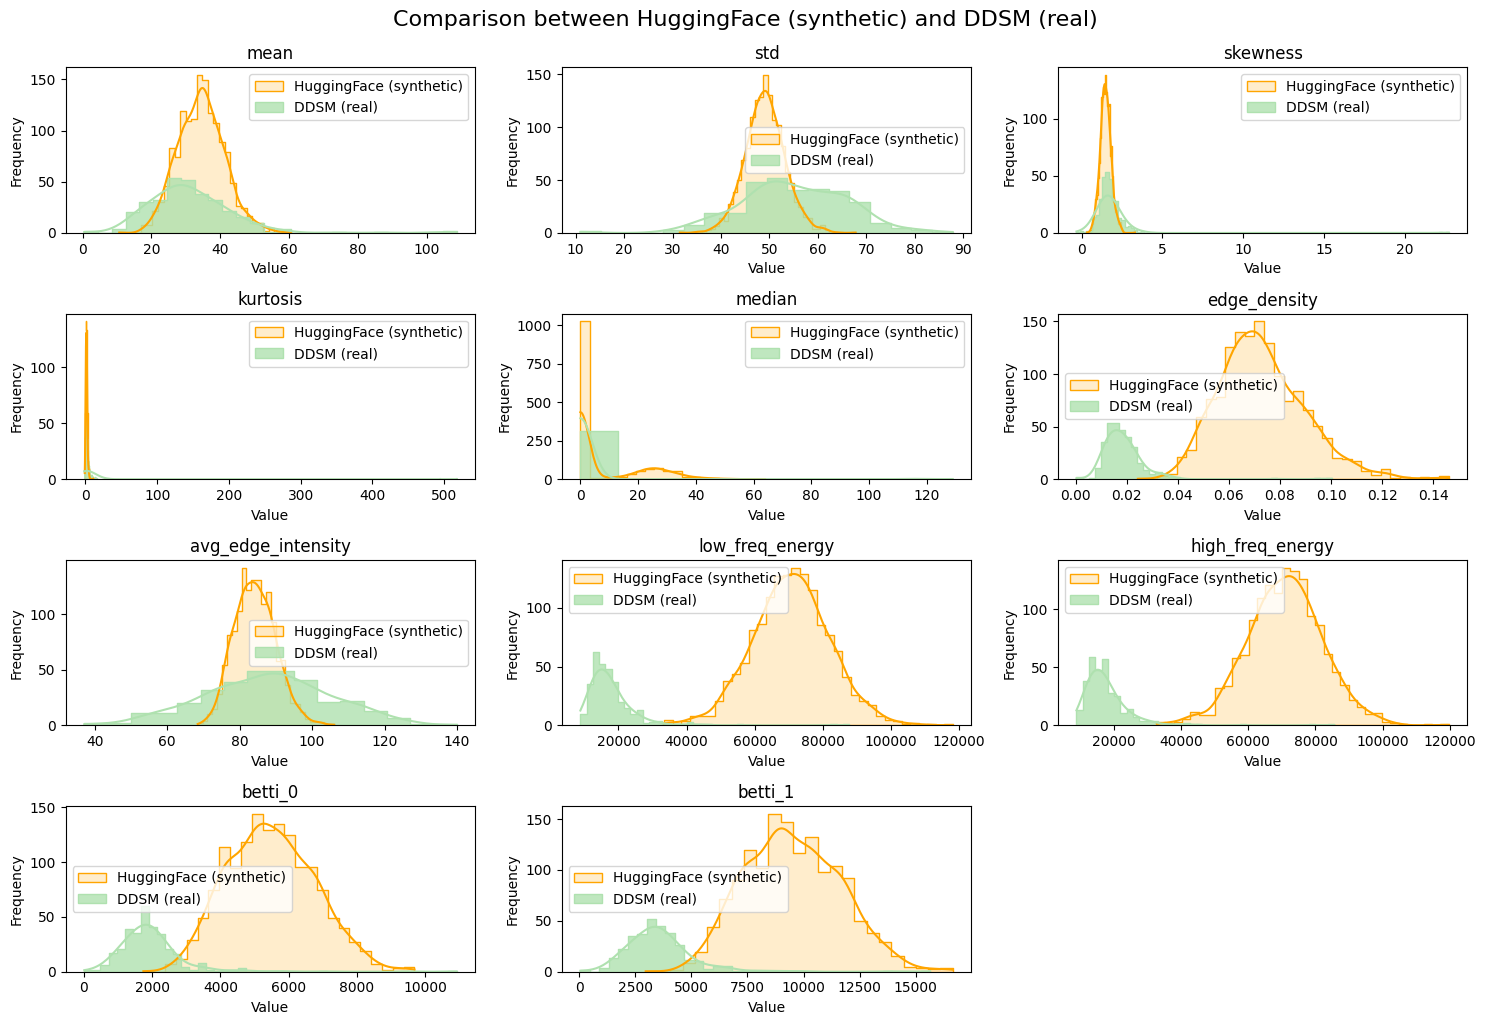

<Figure size 640x480 with 0 Axes>

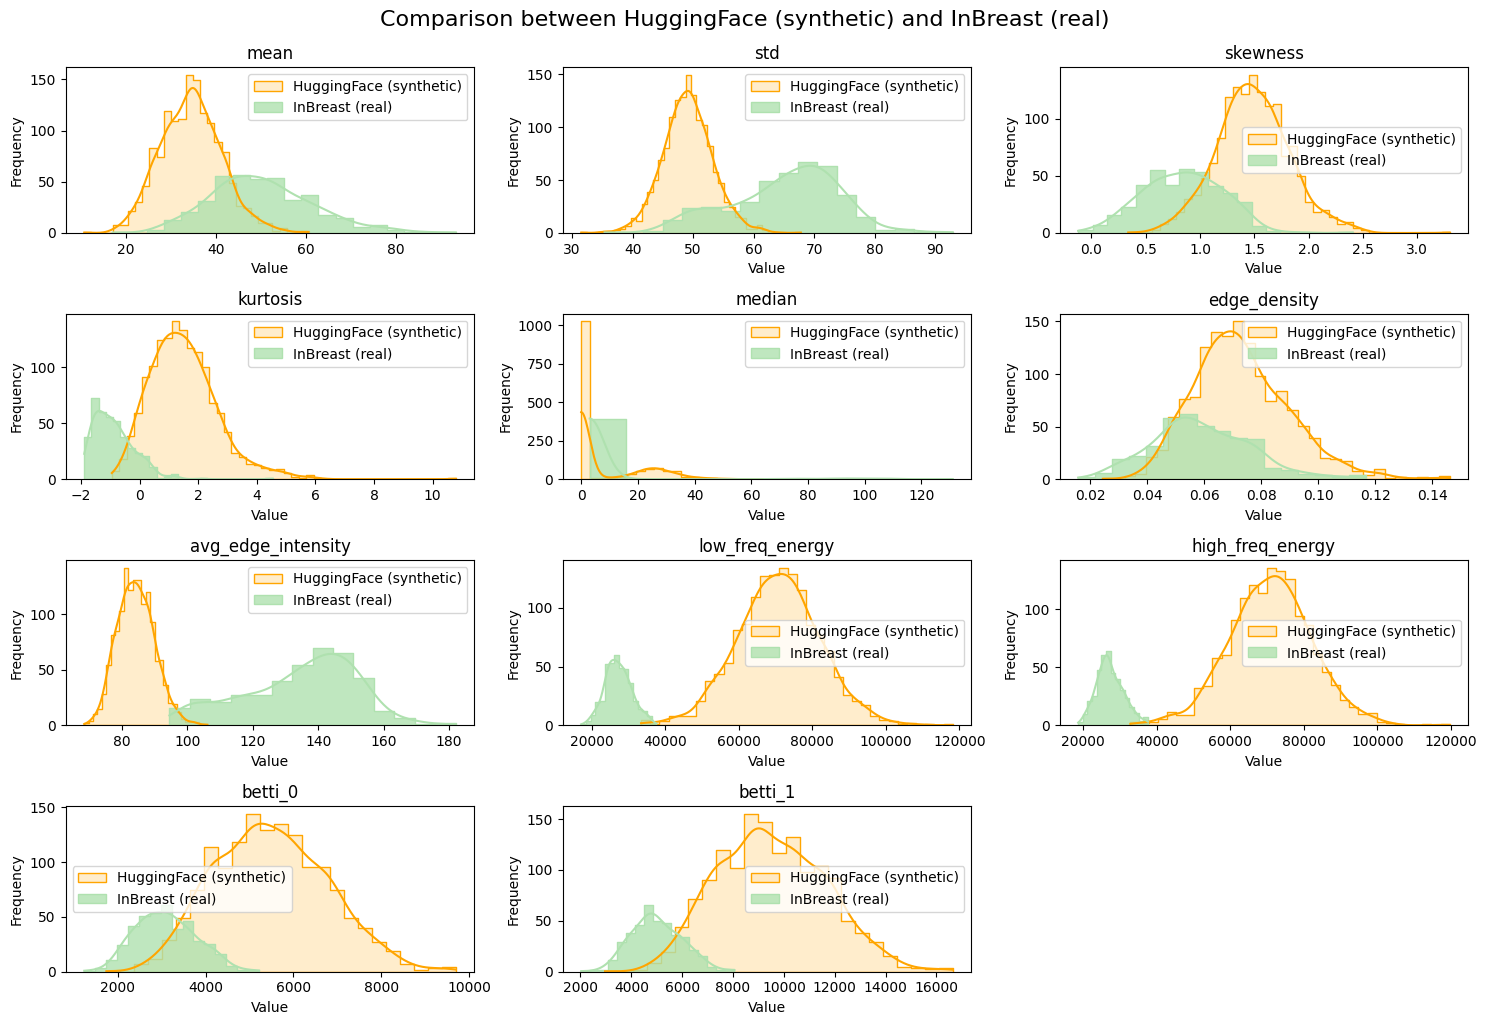

<Figure size 640x480 with 0 Axes>

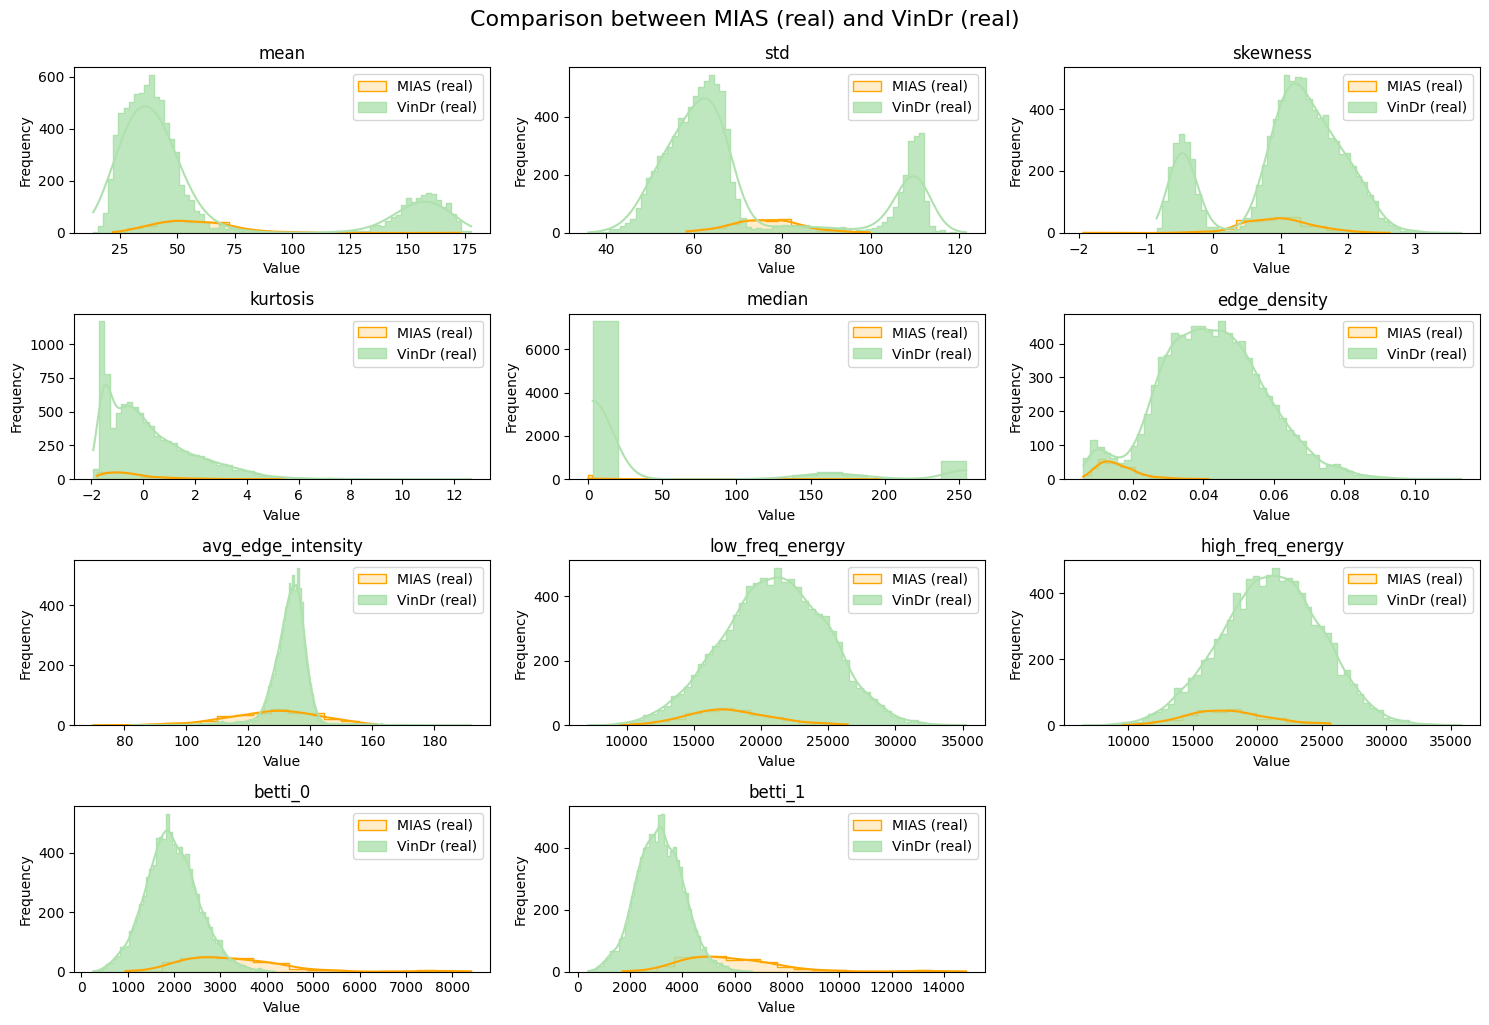

<Figure size 640x480 with 0 Axes>

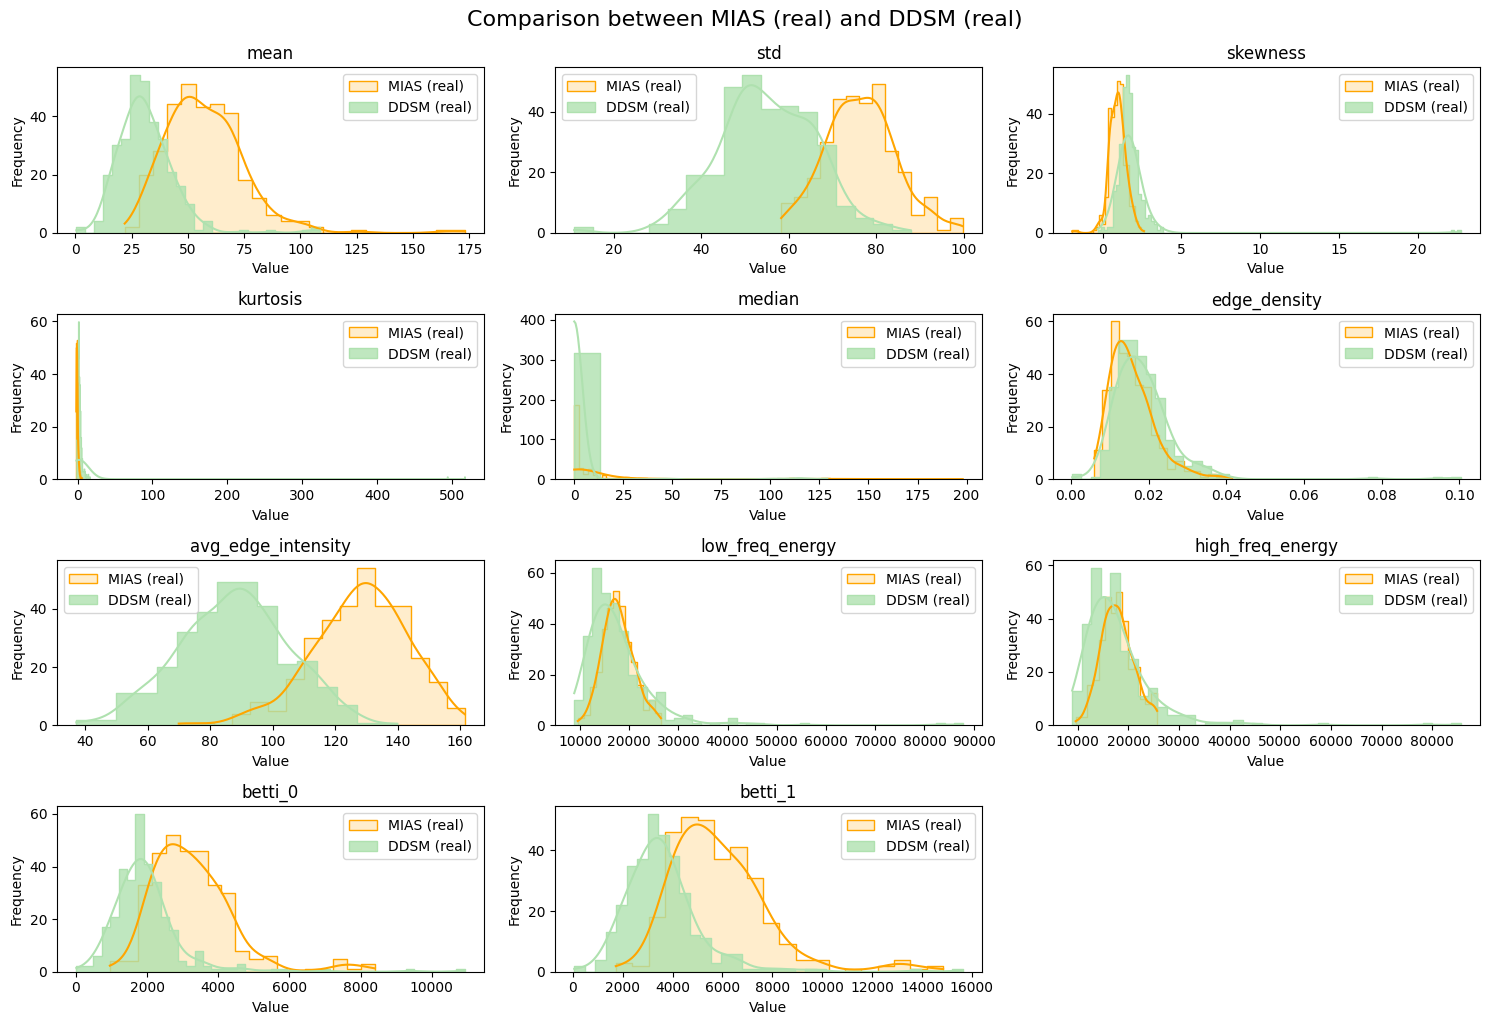

<Figure size 640x480 with 0 Axes>

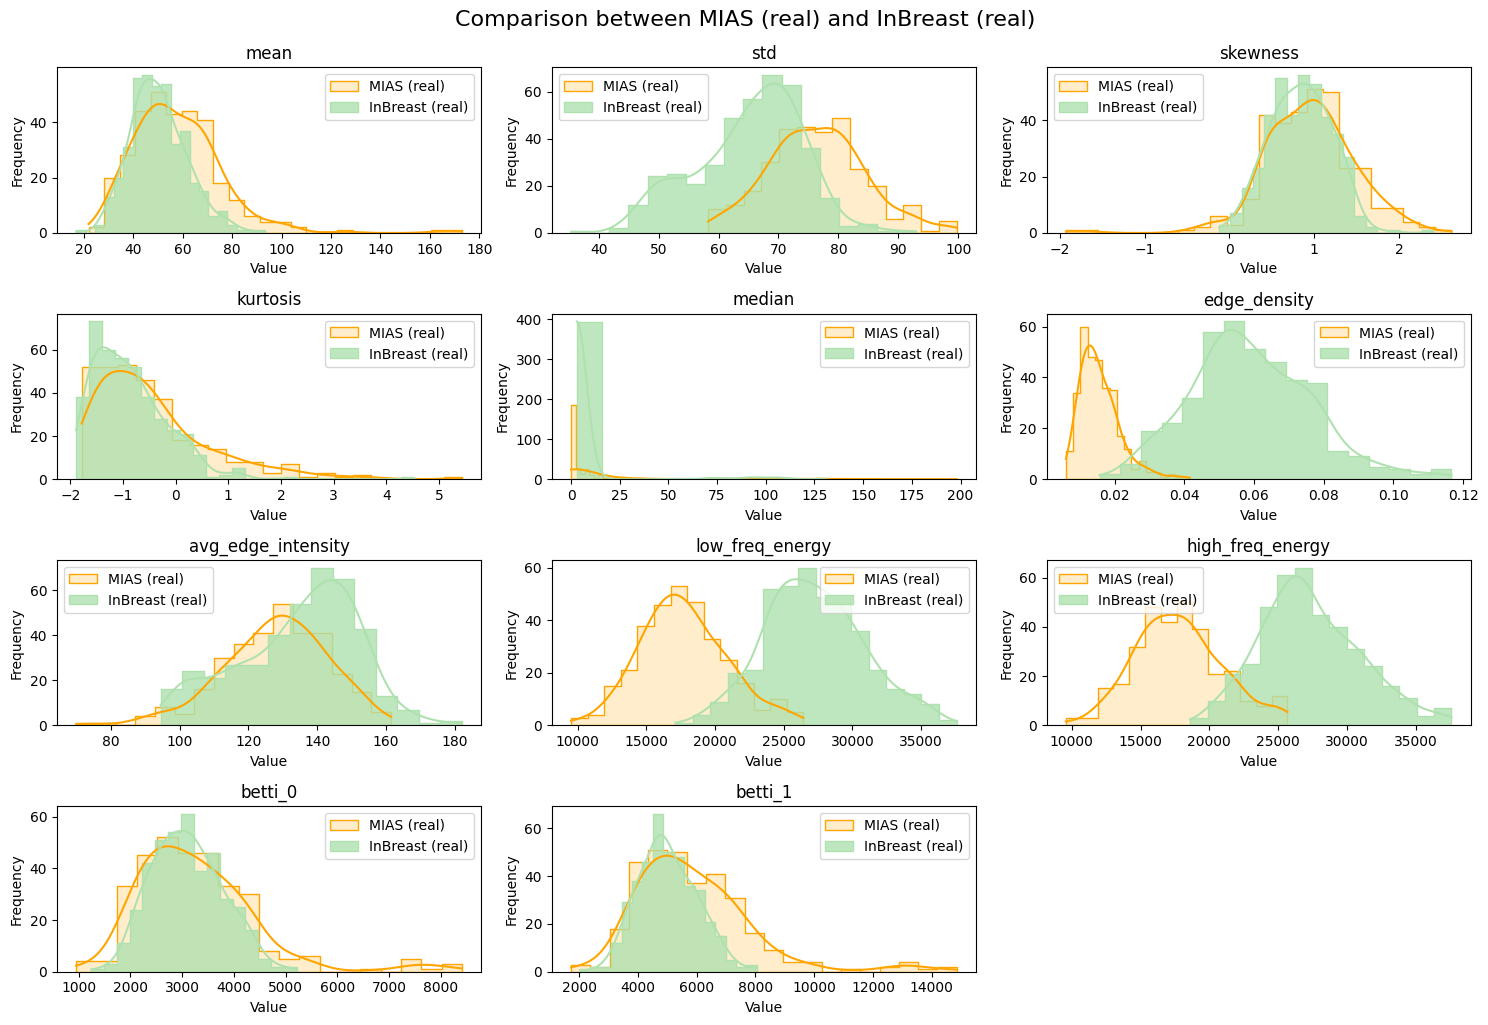

<Figure size 640x480 with 0 Axes>

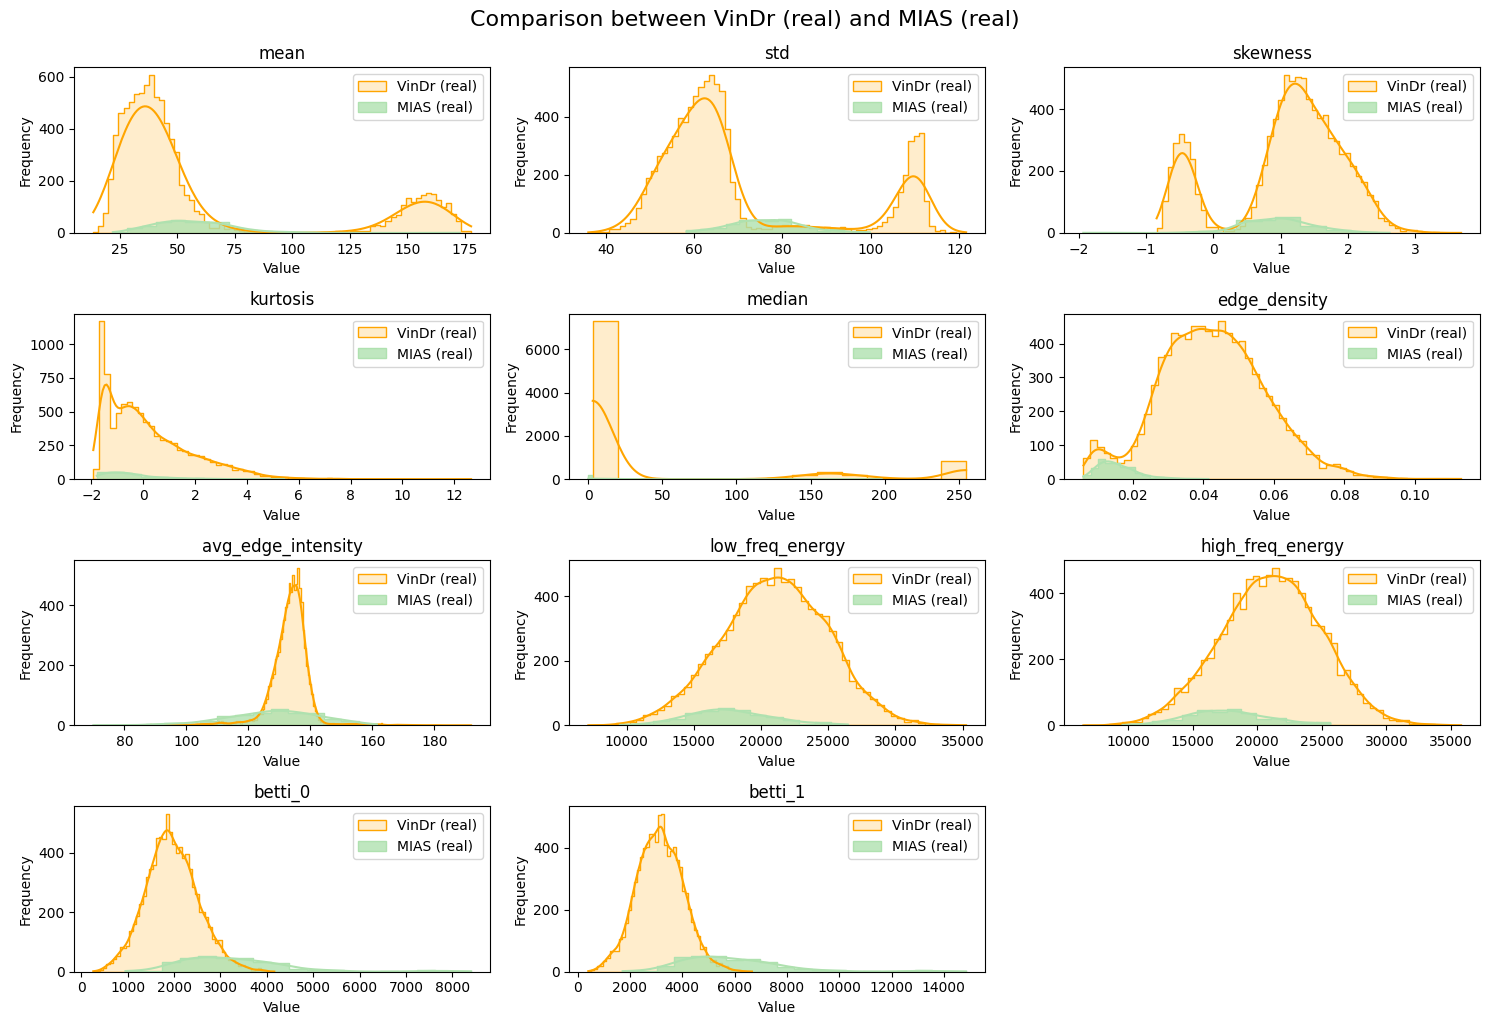

<Figure size 640x480 with 0 Axes>

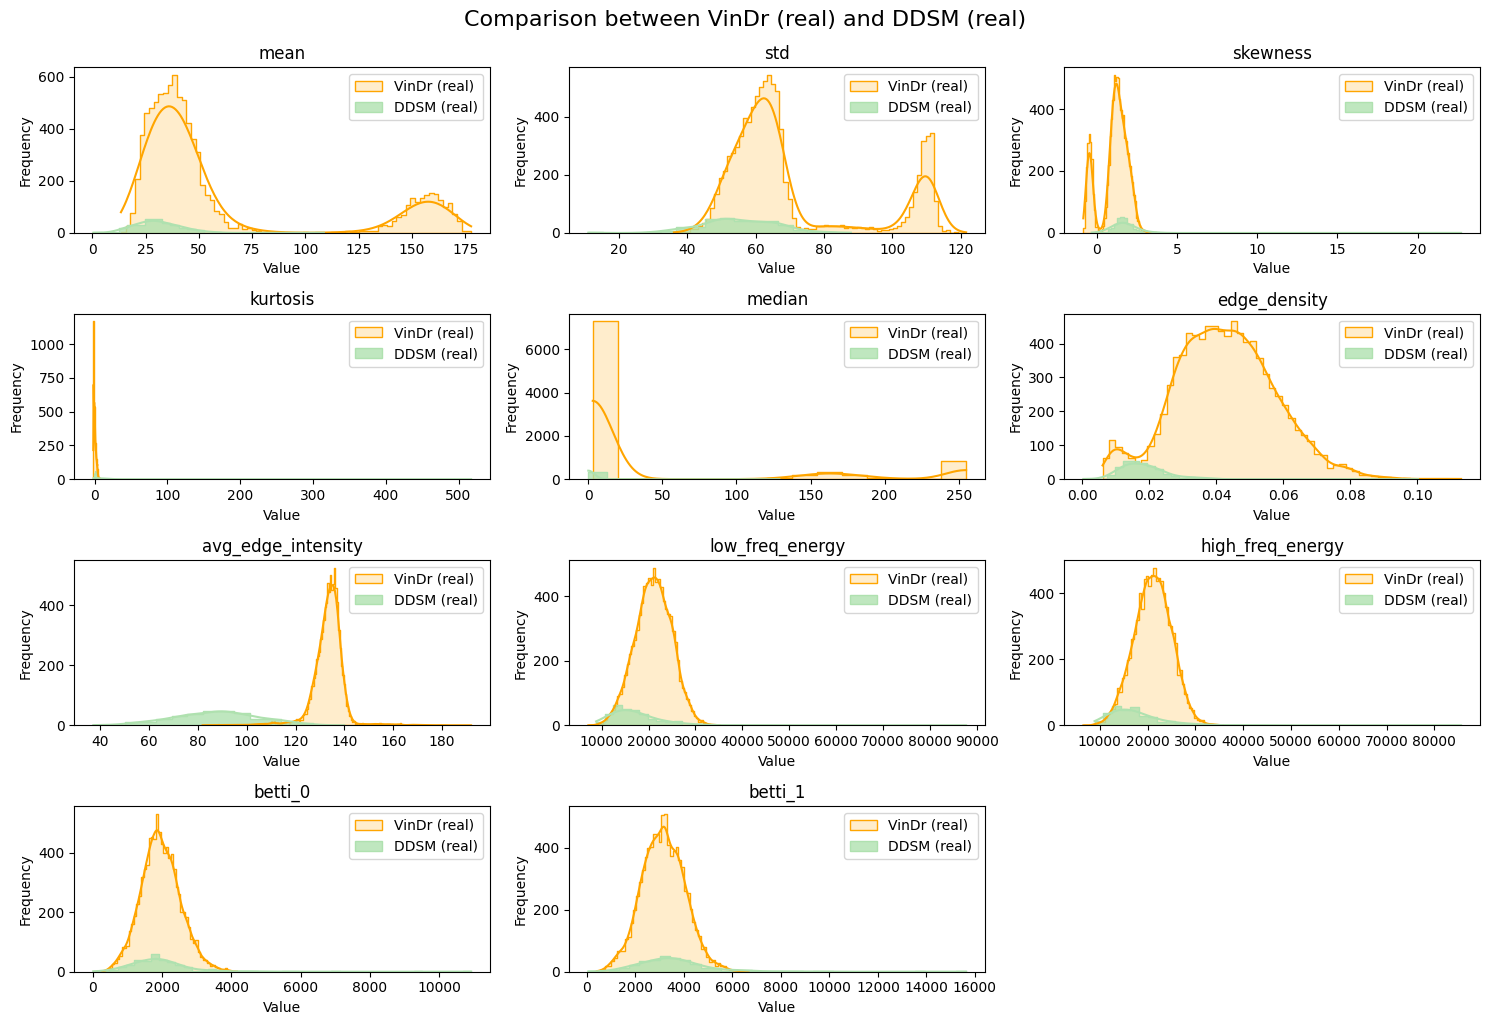

<Figure size 640x480 with 0 Axes>

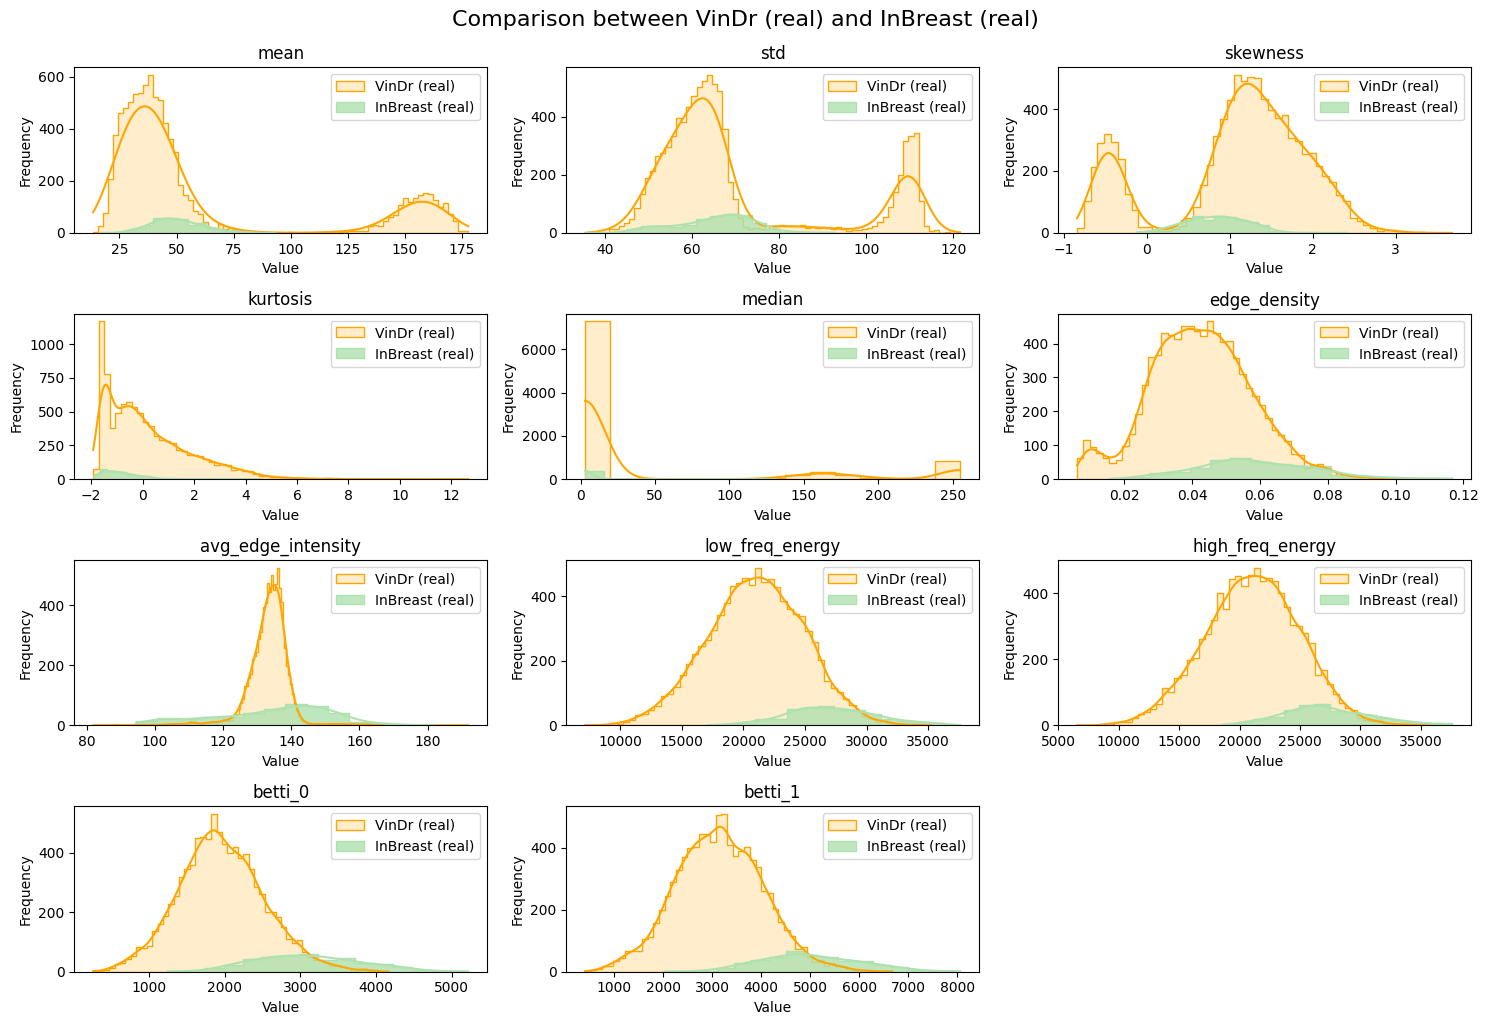

<Figure size 640x480 with 0 Axes>

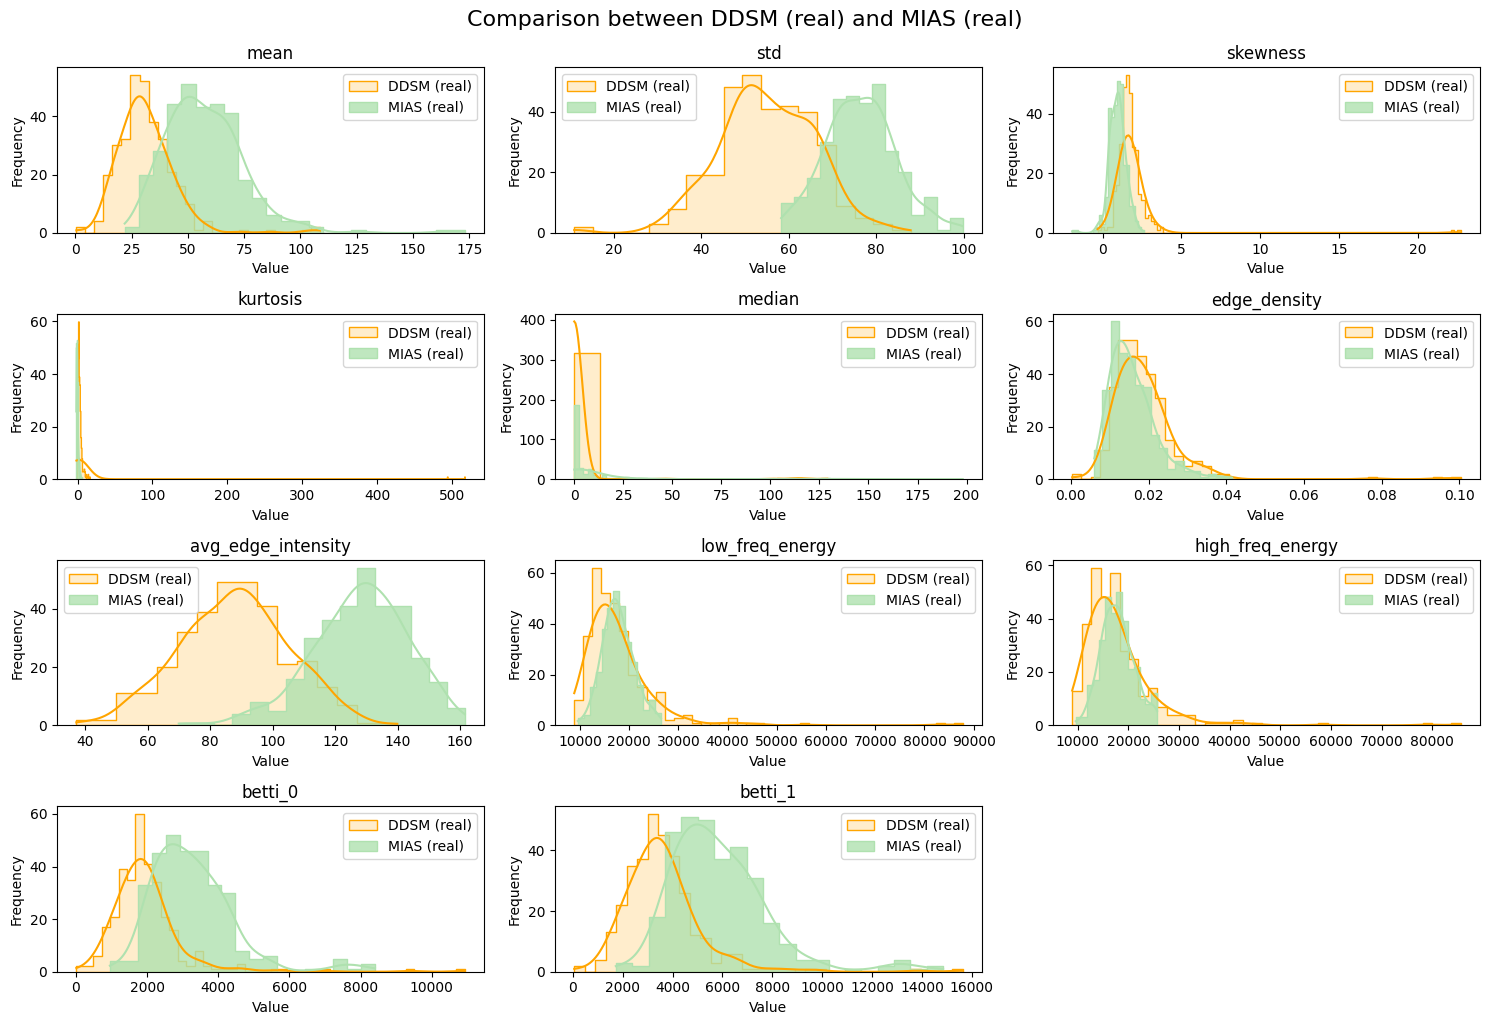

<Figure size 640x480 with 0 Axes>

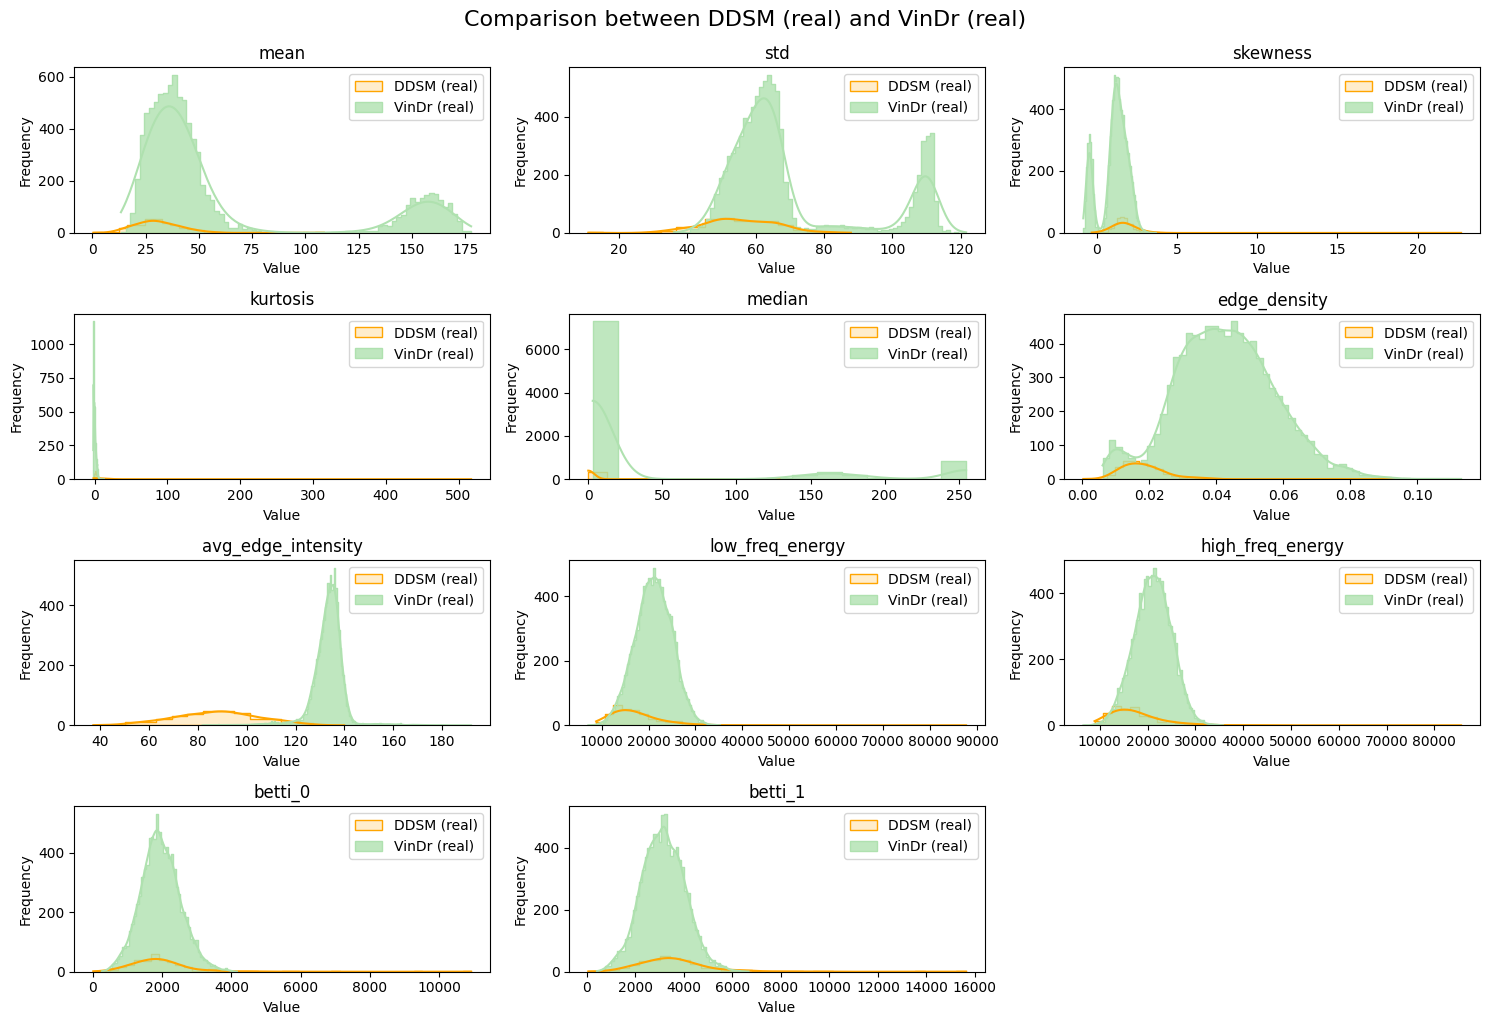

<Figure size 640x480 with 0 Axes>

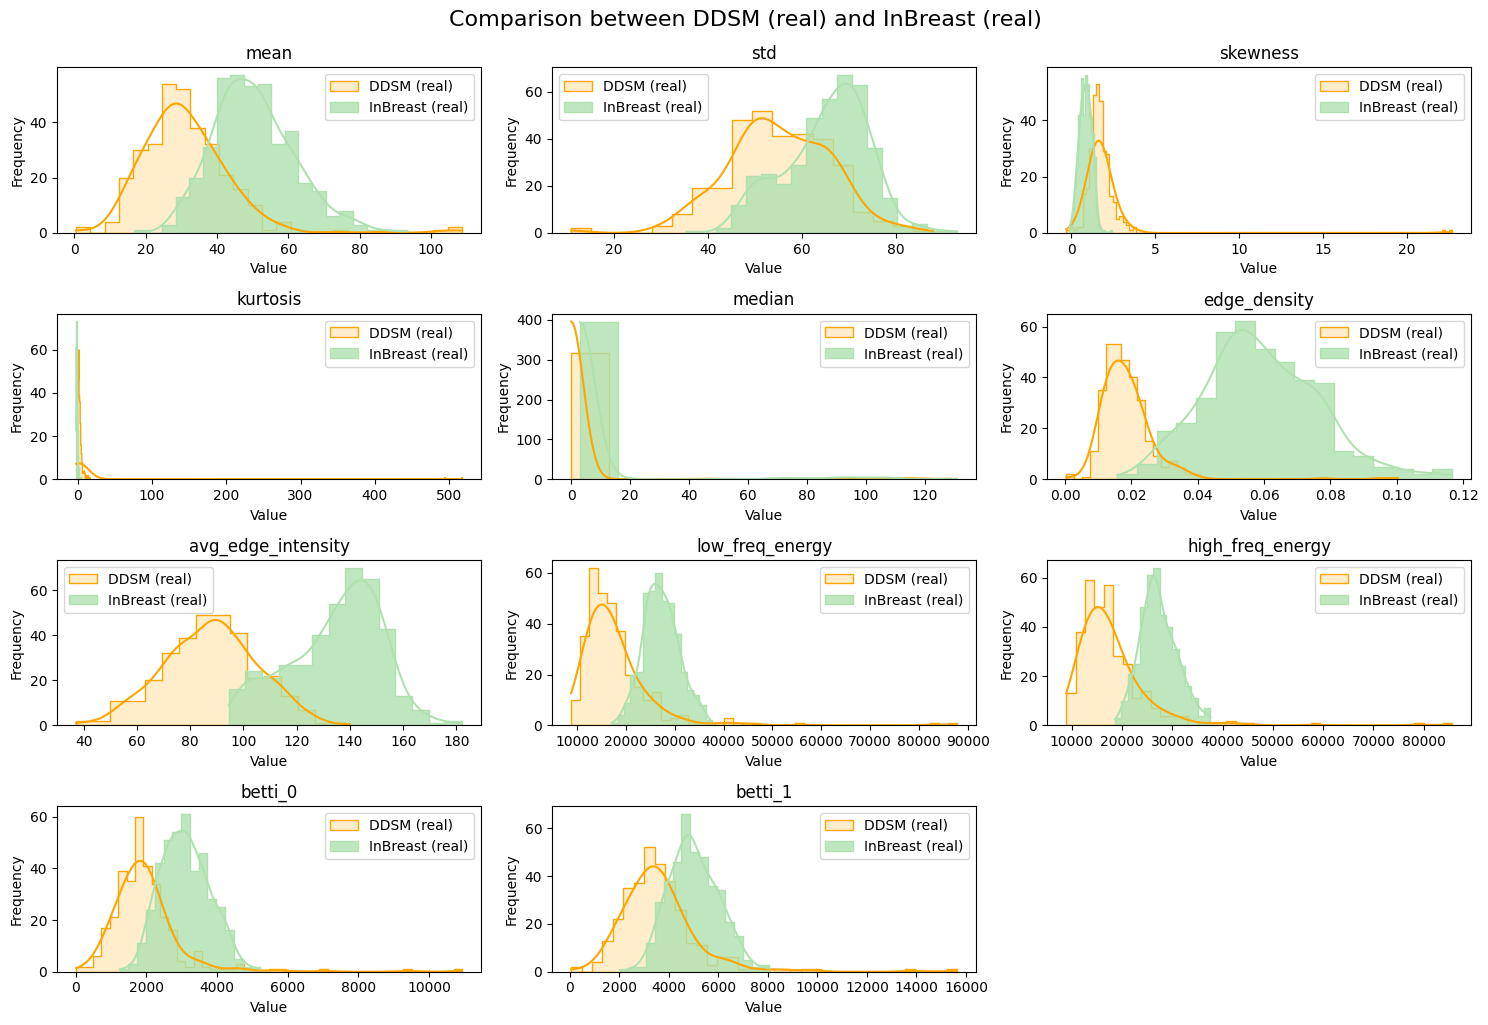

<Figure size 640x480 with 0 Axes>

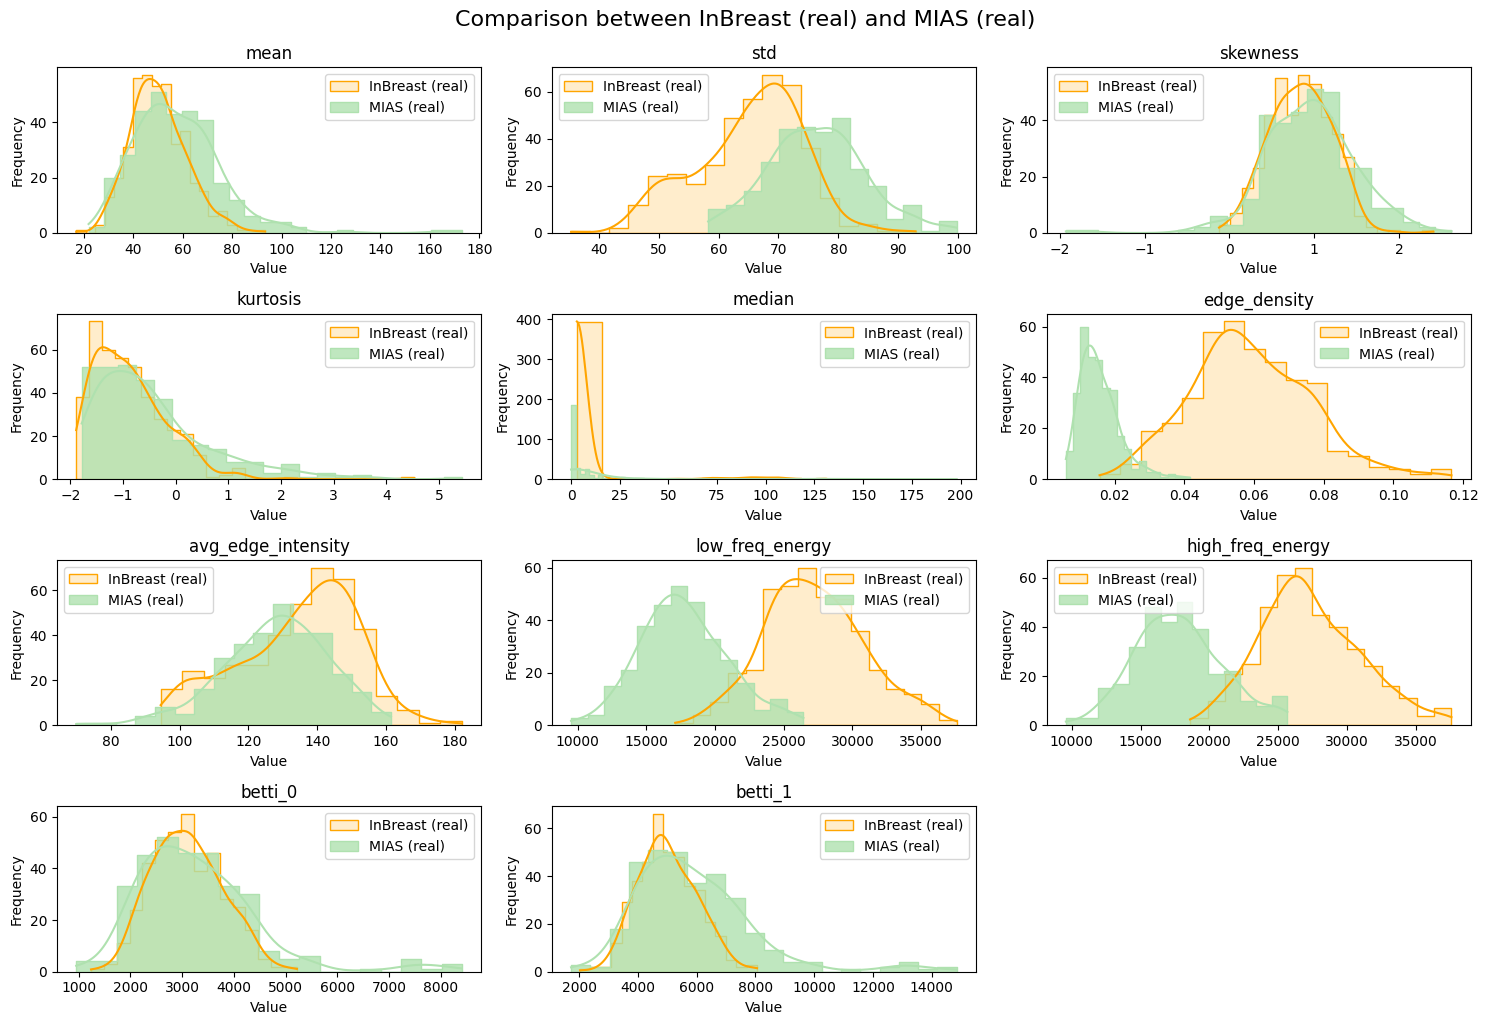

<Figure size 640x480 with 0 Axes>

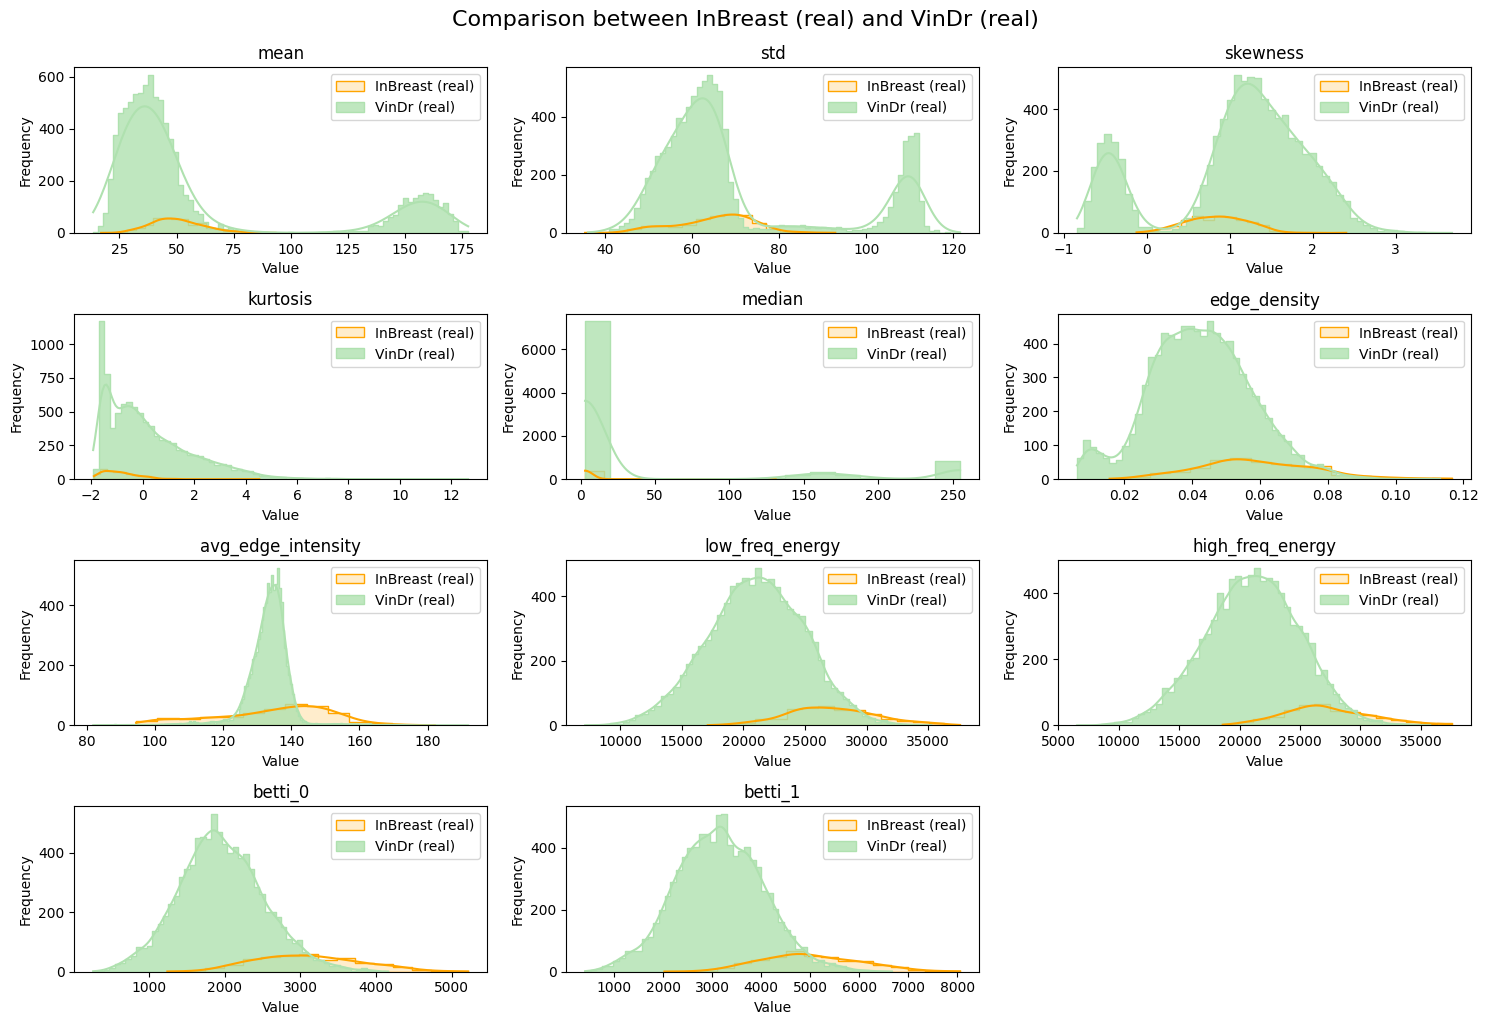

<Figure size 640x480 with 0 Axes>

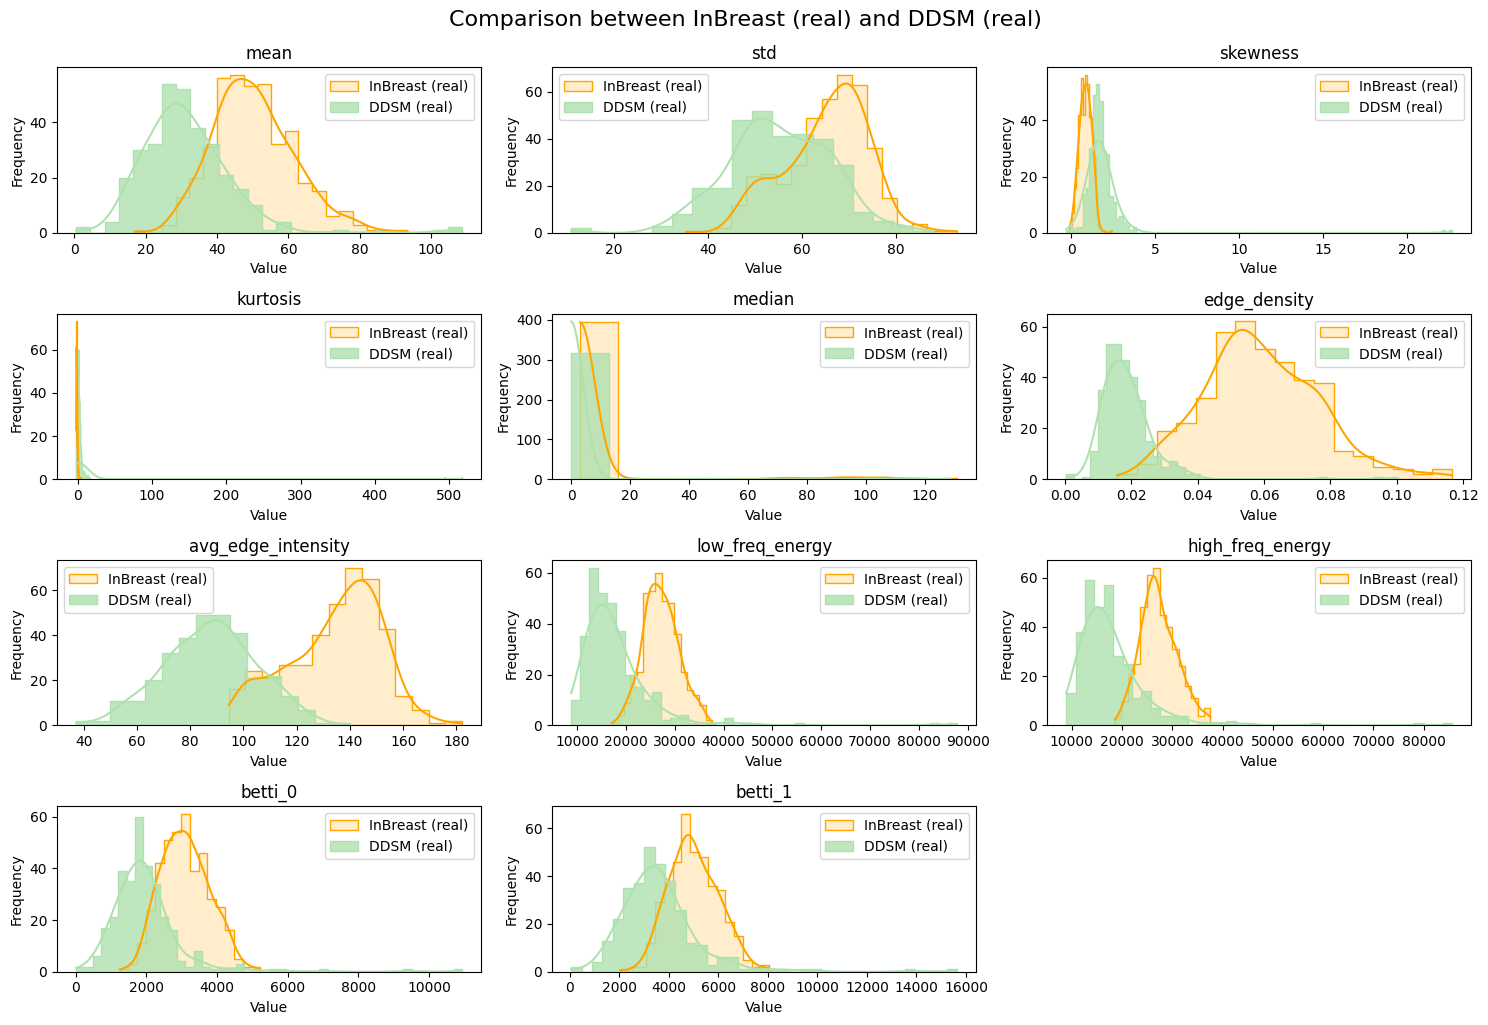

<Figure size 640x480 with 0 Axes>

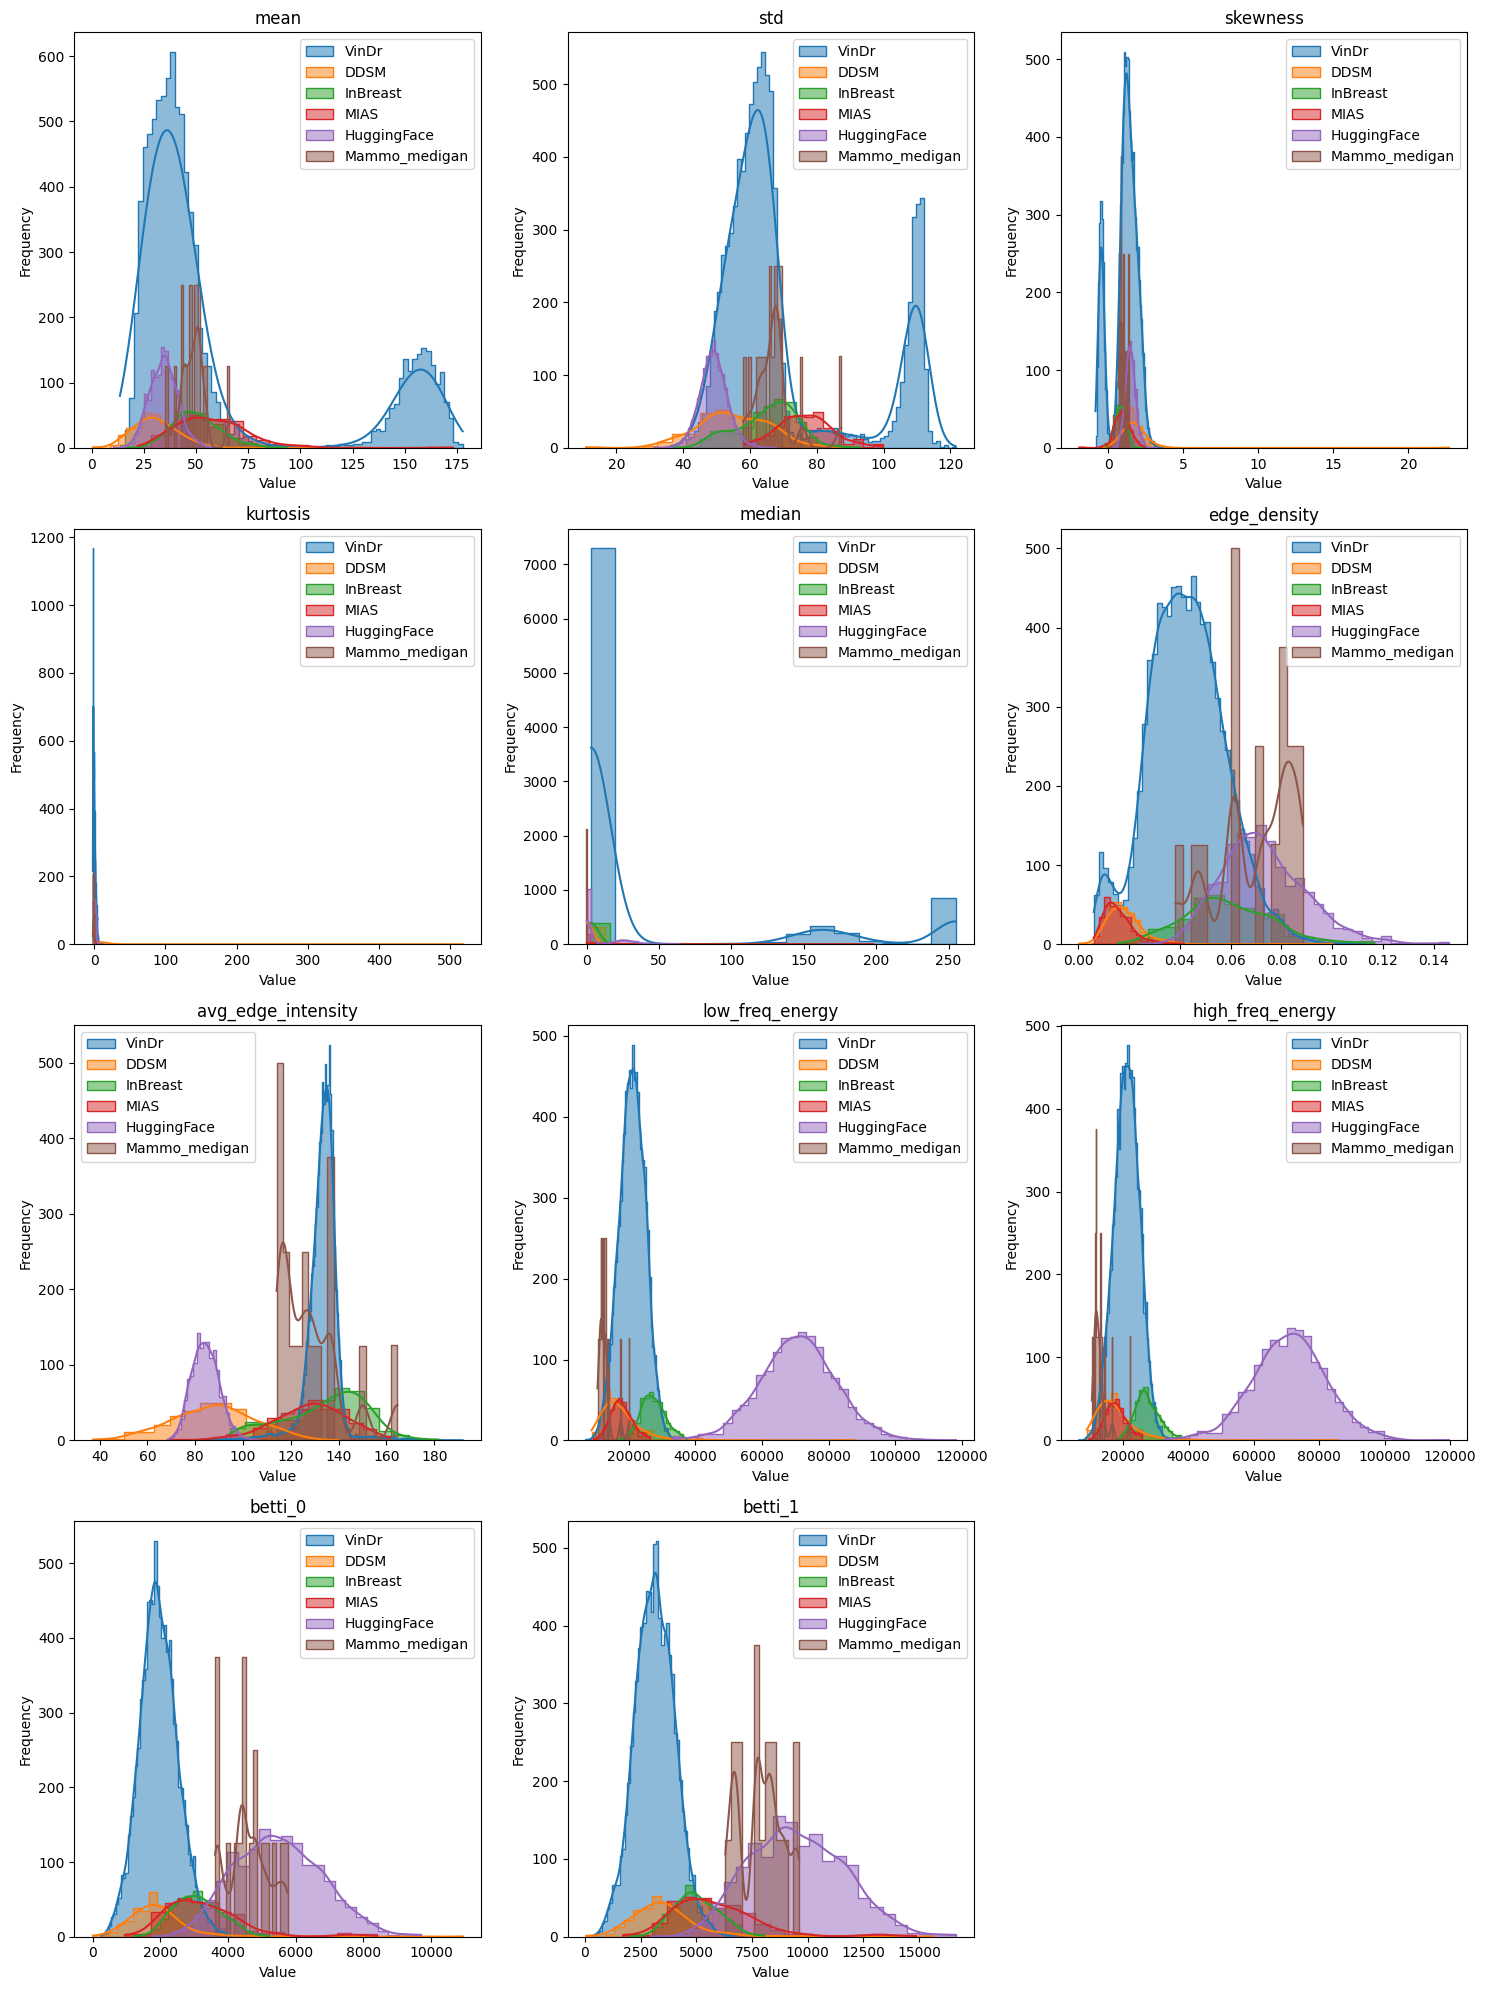

In [6]:
PLOTS_DIR = 'outputs/plots/'
os.makedirs (PLOTS_DIR, exist_ok=True)

# Define groups of synthetic and real datasets
synthetic_datasets = ['Mammo_medigan', 'HuggingFace']
real_datasets = ['MIAS', 'VinDr', 'DDSM', 'InBreast']

# Visualization parameters
dataset1_transparency = 0.2  # Adjust transparency for real datasets
dataset2_color = '#AFE1AF'  # Distinctive color for synthetic datasets
figsize = (15, 10)  # Figure size for plots

# Function to plot comparison between two datasets
def plot_dataset_comparisons (dataset1, dataset2, datatype1, datatype2):

    ''' Plot a set of feature distributions from two sets.

        inputs
        ------
        dataset1 (str): name of the first dataset
        dataset2 (str): name of the second dataset
        datatype1 (str): type of the first dataset (either synthetic or real)
        datatype2 (str): type of the second dataset (either synthetic or real)
    '''

    for index, datatype in enumerate ([datatype1, datatype2]):
        if not datatype in ['synthetic', 'real']:
            raise ValueError (f"Invalid datatype `{datatype}` for dataset {index+1}. Expecting 'synthetic' or 'real'.")

    for index, dataset in enumerate ([dataset1, dataset2]):
        if not dataset in dataset_features.keys():
            raise ValueError (f"Invalid dataset name `{dataset}` for dataset {index+1}. Expecting one of {list(dataset_features.keys())}.")

    plt.figure(figsize=figsize)
    for i, column in enumerate(FEATURE_COLUMNS):
        plt.subplot(4, 3, i + 1)  # Adjust grid size according to number of features
        # Plot dataset 1 histogram
        sns.histplot(dataset_features[dataset1][column], kde=True, element='step',
                     label=f"{dataset1} ({datatype1})", color='orange', alpha=dataset1_transparency)
        # Plot synthetic dataset histogram
        sns.histplot(dataset_features[dataset2][column], kde=True, element='step',
                     label=f"{dataset2} ({datatype2})", color=dataset2_color, alpha=0.8)
        plt.legend()
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.suptitle(f'Comparison between {dataset1} ({datatype1}) and {dataset2} ({datatype2})', fontsize=16, y=1.02)
    plt.show()
    plt.savefig (PLOTS_DIR + f'{dataset1}_Vs_{dataset2}.pdf')

# Function to dump all distributions into one set of plots
def plot_all_datasets():
    plt.figure(figsize=(15, 20))  # Adjust size to better fit a larger grid
    for i, column in enumerate(FEATURE_COLUMNS):
        plt.subplot(4, 3, i + 1)  # Adjust to a 4x3 grid
        for dataset_name, dataset_df in dataset_features.items():
            sns.histplot(dataset_df[column], label=dataset_name, kde=True, element='step')
        plt.legend()
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    #plt.show()
    plt.savefig (PLOTS_DIR + '/all.pdf')

# Plot comparisons between synthetic and real datasets
for synthetic in synthetic_datasets:
    for real in real_datasets:
        plot_dataset_comparisons (synthetic, real, 'synthetic', 'real')

# Plot comparisons between real and real datasets
for real1 in real_datasets:
    for real2 in real_datasets:
        if real1==real2: continue
        plot_dataset_comparisons (real1, real2, 'real', 'real')

# Plot all datasets together
plot_all_datasets()
